<a href="https://colab.research.google.com/github/Shugyla1234/DataScienceEcosystem/blob/main/Project_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
yousefmohamed20_oxford_102_flower_dataset_path = kagglehub.dataset_download('yousefmohamed20/oxford-102-flower-dataset')

print('Data source import complete.')


100%|██████████| 331M/331M [00:04<00:00, 80.9MB/s]

Extracting files...


Data source import complete.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler # <-- This line is correct now
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from tqdm import tqdm

In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class names (provided by the user)
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

# Data transformations
# ImageNet mean and std for normalization
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Resize and crop to 224x224
        transforms.RandomHorizontalFlip(), # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # Resize to 256
        transforms.CenterCrop(224), # Center crop to 224
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
    'test': transforms.Compose([ # Add transformations for the test set
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
}


Using device: cuda:0


In [ ]:
# Define data directory (will be created if not exists)
data_dir = './data/oxford_flowers102'

# Load datasets - NOW INCLUDING 'TEST' SPLIT
image_datasets = {
    'train': datasets.Flowers102(root=data_dir, split='train', download=True, transform=data_transforms['train']),
    'val': datasets.Flowers102(root=data_dir, split='val', download=True, transform=data_transforms['val']),
    'test': datasets.Flowers102(root=data_dir, split='test', download=True, transform=data_transforms['test']), # Added test split
}

# Create data loaders - NOW INCLUDING 'TEST' SPLIT
# Shuffle is typically False for the test set
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4), # Shuffle False for test
}



100%|██████████| 345M/345M [00:21<00:00, 15.8MB/s]
100%|██████████| 502/502 [00:00<00:00, 791kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 23.3MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']} # Updated dataset_sizes
num_classes = len(class_names)

print(f"Number of training images: {dataset_sizes['train']}")
print(f"Number of validation images: {dataset_sizes['val']}")
print(f"Number of test images: {dataset_sizes['test']}") # Print test size
print(f"Number of classes: {num_classes}")

# Optional: Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp * normalize_std + normalize_mean, 0, 1) # Unnormalize
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data and visualize
# inputs, labels = next(iter(dataloaders['train']))
# out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[class_names[x] for x in labels])
# plt.show()

Number of training images: 1020
Number of validation images: 1020
Number of test images: 6149
Number of classes: 102


In [ ]:
# --- Training Function (remains the same) ---
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []


    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else: # phase == 'val'
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())


            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies # Return history

In [ ]:
# --- Evaluation Function (reused for test) ---
def evaluate_model(model, dataloader, phase='test'):
    model.eval() # Set model to evaluate mode
    running_corrects = 0
    total_samples = 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss() # Need a criterion for test loss

    print(f"Evaluating on {phase} set...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Evaluating {phase}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels) # Calculate loss for test set

            total_samples += labels.size(0)
            running_corrects += torch.sum(preds == labels.data)
            running_loss += loss.item() * inputs.size(0)

    accuracy = running_corrects.double() / total_samples
    avg_loss = running_loss / total_samples
    print(f'{phase} Loss: {avg_loss:.4f} Acc: {accuracy:.4f}')
    return accuracy, avg_loss



# --- ResNet18 Implementation ---
print("\n--- Training ResNet18 ---")
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs_resnet18 = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs_resnet18, num_classes)
model_resnet18 = model_resnet18.to(device)

criterion_resnet18 = nn.CrossEntropyLoss()
optimizer_resnet18 = optim.Adam(model_resnet18.parameters(), lr=0.001)
exp_lr_scheduler_resnet18 = lr_scheduler.StepLR(optimizer_resnet18, step_size=7, gamma=0.1)

# Capture history from train_model
model_resnet18_trained, resnet18_train_losses, resnet18_train_accuracies, resnet18_val_losses, resnet18_val_accuracies = train_model(
    model_resnet18,
    criterion_resnet18,
    optimizer_resnet18,
    exp_lr_scheduler_resnet18,
    num_epochs=15 # You can adjust the number of epochs
)
torch.save(model_resnet18_trained.state_dict(), 'resnet18_oxford_flowers102.pth')
print("ResNet18 model saved to resnet18_oxford_flowers102.pth")
"""
To visualize the loss and accuracy graphs for ResNet-18 and ResNet-50, you can use the plot_training_history function that was already included in the previous code snippets.

You'll need to call this function after you have trained each ResNet model and captured its training history (losses and accuracies).

Here's how you would integrate it:

Python

# Assuming you have loaded and trained ResNet-18 and ResNet-50 models
# and captured their training history in variables like:
# resnet18_train_losses, resnet18_train_accuracies, resnet18_val_losses, resnet18_val_accuracies
# resnet50_train_losses, resnet50_train_accuracies, resnet50_val_losses, resnet50_val_accuracies

# Make sure the 'plot_training_history' function definition is present in your script.
# (It's already in the comprehensive code I provided previously).

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = range(len(train_losses))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{model_name} Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- Where to place the code for ResNet-18 ---
# AFTER you have called train_model for ResNet-18 and stored its outputs
# For example, if you had a training block like this:
# model_resnet18_trained, resnet18_train_losses, resnet18_train_accuracies, resnet18_val_losses, resnet18_val_accuracies = train_model(...)

print("\n--- Plotting Training History for ResNet-18 ---")
plot_training_history(
    resnet18_train_losses,
    resnet18_val_losses,
    resnet18_train_accuracies,
    resnet18_val_accuracies,
    "ResNet-18"
)

# --- Where to place the code for ResNet-50 ---
# Similarly, AFTER you have called train_model for ResNet-50 and stored its outputs
# For example, if you had a training block like this:
# model_resnet50_trained, resnet50_train_losses, resnet50_train_accuracies, resnet50_val_losses, resnet50_val_accuracies = train_model(...)


"""
)

SyntaxError: unmatched ')' (ipython-input-11-547812406.py, line 115)

In [ ]:
# --- ResNet50 Implementation ---
print("\n--- Training ResNet50 ---")
model_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs_resnet50 = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs_resnet50, num_classes)
model_resnet50 = model_resnet50.to(device)

criterion_resnet50 = nn.CrossEntropyLoss()
optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=0.001)
exp_lr_scheduler_resnet50 = lr_scheduler.StepLR(optimizer_resnet50, step_size=7, gamma=0.1)

model_resnet50_trained, resnet50_train_losses, resnet50_train_accuracies, resnet50_val_losses, resnet50_val_accuracies = train_model(
    model_resnet50,
    criterion_resnet50,
    optimizer_resnet50,
    exp_lr_scheduler_resnet50,
    num_epochs=15 # You can adjust the number of epochs
)
torch.save(model_resnet50_trained.state_dict(), 'resnet50_oxford_flowers102.pth')
print("ResNet50 model saved to resnet50_oxford_flowers102.pth")


--- Training ResNet50 ---


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 128MB/s]


Epoch 0/14
----------


train Epoch 0: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


train Loss: 3.8902 Acc: 0.1765


val Epoch 0: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


val Loss: 2.9613 Acc: 0.3314

Epoch 1/14
----------


train Epoch 1: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


train Loss: 1.9499 Acc: 0.5020


val Epoch 1: 100%|██████████| 32/32 [00:06<00:00,  5.06it/s]


val Loss: 2.2045 Acc: 0.5127

Epoch 2/14
----------


train Epoch 2: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


train Loss: 1.2493 Acc: 0.6598


val Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


val Loss: 1.9944 Acc: 0.5490

Epoch 3/14
----------


train Epoch 3: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


train Loss: 0.9921 Acc: 0.7422


val Epoch 3: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


val Loss: 1.5161 Acc: 0.6451

Epoch 4/14
----------


train Epoch 4: 100%|██████████| 32/32 [00:11<00:00,  2.86it/s]


train Loss: 0.7395 Acc: 0.8078


val Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  5.16it/s]


val Loss: 1.0394 Acc: 0.7314

Epoch 5/14
----------


train Epoch 5: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]


train Loss: 0.6178 Acc: 0.8265


val Epoch 5: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


val Loss: 0.8608 Acc: 0.7912

Epoch 6/14
----------


train Epoch 6: 100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


train Loss: 0.4414 Acc: 0.8824


val Epoch 6: 100%|██████████| 32/32 [00:06<00:00,  5.02it/s]


val Loss: 0.8879 Acc: 0.7912

Epoch 7/14
----------


train Epoch 7: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


train Loss: 0.2896 Acc: 0.9245


val Epoch 7: 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]


val Loss: 0.4999 Acc: 0.8765

Epoch 8/14
----------


train Epoch 8: 100%|██████████| 32/32 [00:11<00:00,  2.91it/s]


train Loss: 0.2000 Acc: 0.9539


val Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  5.24it/s]


val Loss: 0.4562 Acc: 0.8980

Epoch 9/14
----------


train Epoch 9: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


train Loss: 0.1624 Acc: 0.9608


val Epoch 9: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s]


val Loss: 0.4293 Acc: 0.8990

Epoch 10/14
----------


train Epoch 10: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


train Loss: 0.1539 Acc: 0.9608


val Epoch 10: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s]


val Loss: 0.4206 Acc: 0.9039

Epoch 11/14
----------


train Epoch 11: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


train Loss: 0.1379 Acc: 0.9627


val Epoch 11: 100%|██████████| 32/32 [00:06<00:00,  5.20it/s]


val Loss: 0.4098 Acc: 0.9059

Epoch 12/14
----------


train Epoch 12: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


train Loss: 0.1695 Acc: 0.9578


val Epoch 12: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]


val Loss: 0.3938 Acc: 0.9118

Epoch 13/14
----------


train Epoch 13: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


train Loss: 0.1256 Acc: 0.9706


val Epoch 13: 100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


val Loss: 0.3883 Acc: 0.9088

Epoch 14/14
----------


train Epoch 14: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


train Loss: 0.1511 Acc: 0.9569


val Epoch 14: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


val Loss: 0.3850 Acc: 0.9137

Training complete in 4m 31s
Best val Acc: 0.9137
ResNet50 model saved to resnet50_oxford_flowers102.pth


In [ ]:

# --- Final Evaluation on Test Set ---
print("\n--- Final Evaluation on Test Set ---")

# Evaluate ResNet18 on the test set
print("Evaluating ResNet18 on Test Set:")
test_acc_resnet18, test_loss_resnet18 = evaluate_model(model_resnet18_trained, dataloaders['test'], phase='test')
print(f"ResNet18 Test Accuracy: {test_acc_resnet18:.4f}")
print(f"ResNet18 Test Loss: {test_loss_resnet18:.4f}")


# Evaluate ResNet50 on the test set
print("\nEvaluating ResNet50 on Test Set:")
test_acc_resnet50, test_loss_resnet50 = evaluate_model(model_resnet50_trained, dataloaders['test'], phase='test')
print(f"ResNet50 Test Accuracy: {test_acc_resnet50:.4f}")
print(f"ResNet50 Test Loss: {test_loss_resnet50:.4f}")


--- Final Evaluation on Test Set ---
Evaluating ResNet18 on Test Set:
Evaluating on test set...


Evaluating test: 100%|██████████| 193/193 [00:34<00:00,  5.52it/s]


test Loss: 0.5333 Acc: 0.8624
ResNet18 Test Accuracy: 0.8624
ResNet18 Test Loss: 0.5333

Evaluating ResNet50 on Test Set:
Evaluating on test set...


Evaluating test: 100%|██████████| 193/193 [00:38<00:00,  5.07it/s]

test Loss: 0.4993 Acc: 0.8832
ResNet50 Test Accuracy: 0.8832
ResNet50 Test Loss: 0.4993


In [ ]:
pip install matplotlib numpy scikit-learn seaborn


--- Visualizing ResNet18 Predictions ---


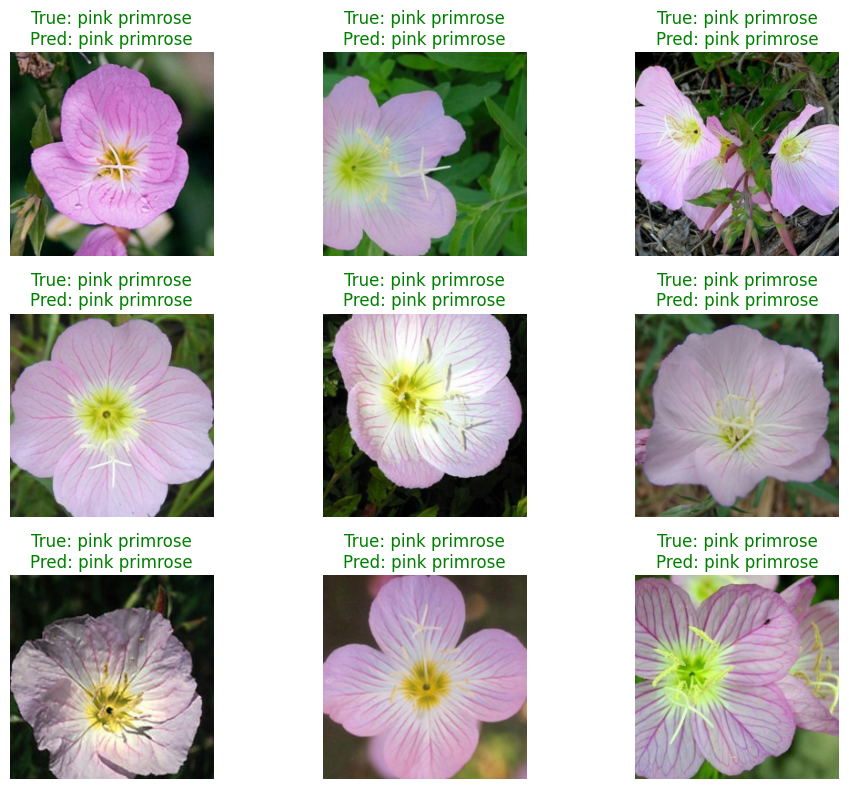


--- Visualizing ResNet50 Predictions ---


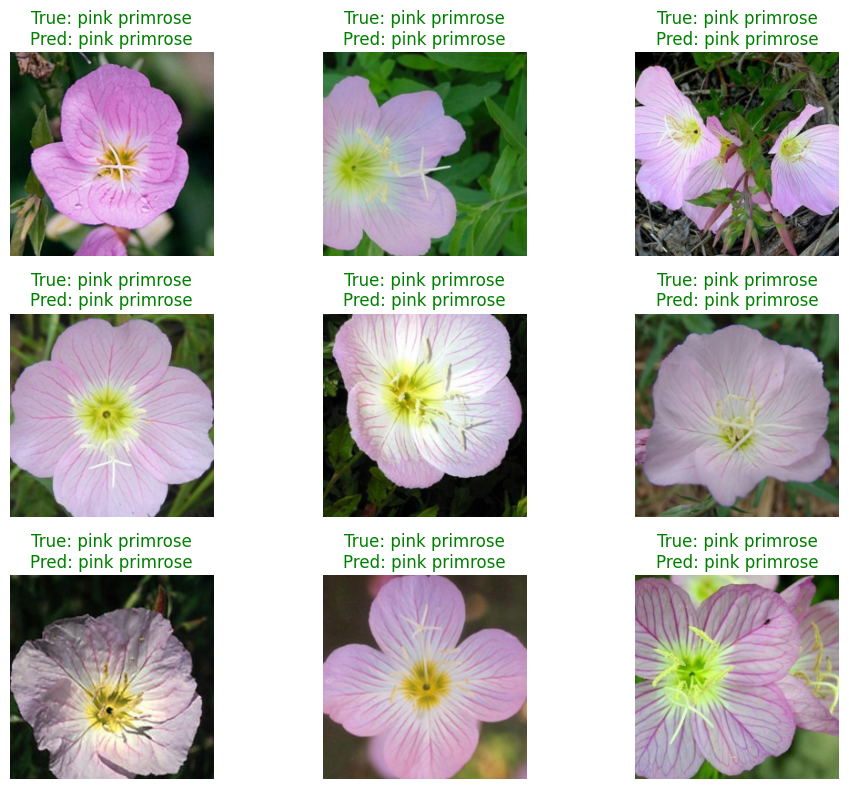

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch

# Ensure you have your class_names defined from earlier
# class_names = ['pink primrose', 'hard-leaved pocket orchid', ..., 'blackberry lily']

# (Make sure these are still defined from your previous code block)
# normalize_mean = [0.485, 0.456, 0.406]
# normalize_std = [0.229, 0.224, 0.225]
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow_unnormalized(inp, title=None):
    """Imshow for a Tensor, unnormalizing it first."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Unnormalize
    inp = inp * np.array(normalize_std) + np.array(normalize_mean)
    inp = np.clip(inp, 0, 1) # Clip values to [0, 1] to ensure valid image display
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off') # Hide axes

def visualize_predictions(model, dataloader, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far < num_images:
                    images_so_far += 1
                    ax = fig.add_subplot(num_images // 3, 3, images_so_far, xticks=[], yticks=[])
                    ax.axis('off')

                    # Get image for plotting
                    img_to_show = inputs.cpu().data[j]
                    # Get true and predicted labels
                    true_label = class_names[labels[j]]
                    pred_label = class_names[preds[j]]

                    # Set title with color for correct/incorrect predictions
                    title_color = "green" if pred_label == true_label else "red"
                    ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=title_color)

                    imshow_unnormalized(img_to_show)

                else:
                    break
            if images_so_far == num_images:
                break
    plt.tight_layout()
    plt.show()


print("\n--- Visualizing ResNet18 Predictions ---")
visualize_predictions(model_resnet18_trained, dataloaders['test'], class_names, num_images=9)

print("\n--- Visualizing ResNet50 Predictions ---")
visualize_predictions(model_resnet50_trained, dataloaders['test'], class_names, num_images=9)


--- Confusion Matrix for ResNet18 (Test Set) ---


Generating Confusion Matrix:   0%|          | 0/193 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Generating Confusion Matrix: 100%|██████████| 193/193 [00:38<00:00,  5.07it/s]


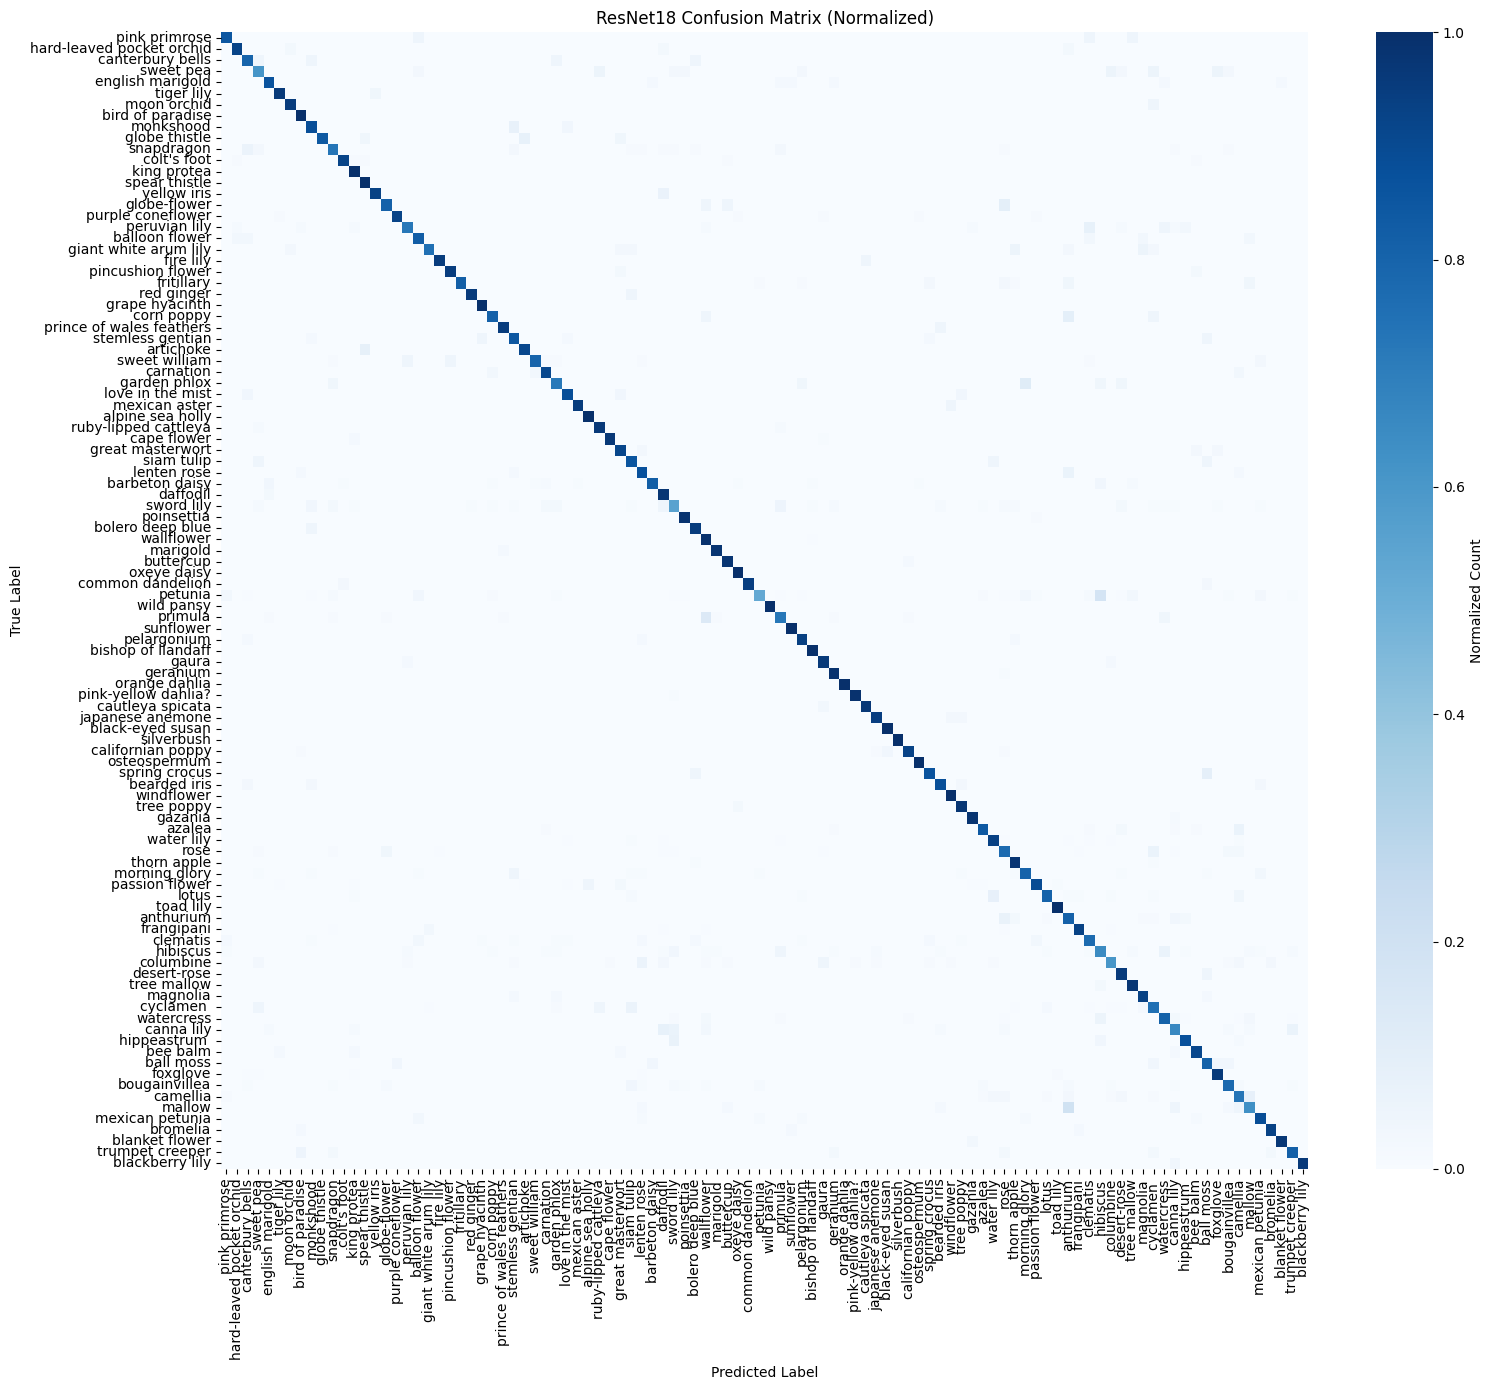


--- Confusion Matrix for ResNet50 (Test Set) ---


Generating Confusion Matrix:   0%|          | 0/193 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Generating Confusion Matrix: 100%|██████████| 193/193 [00:39<00:00,  4.93it/s]


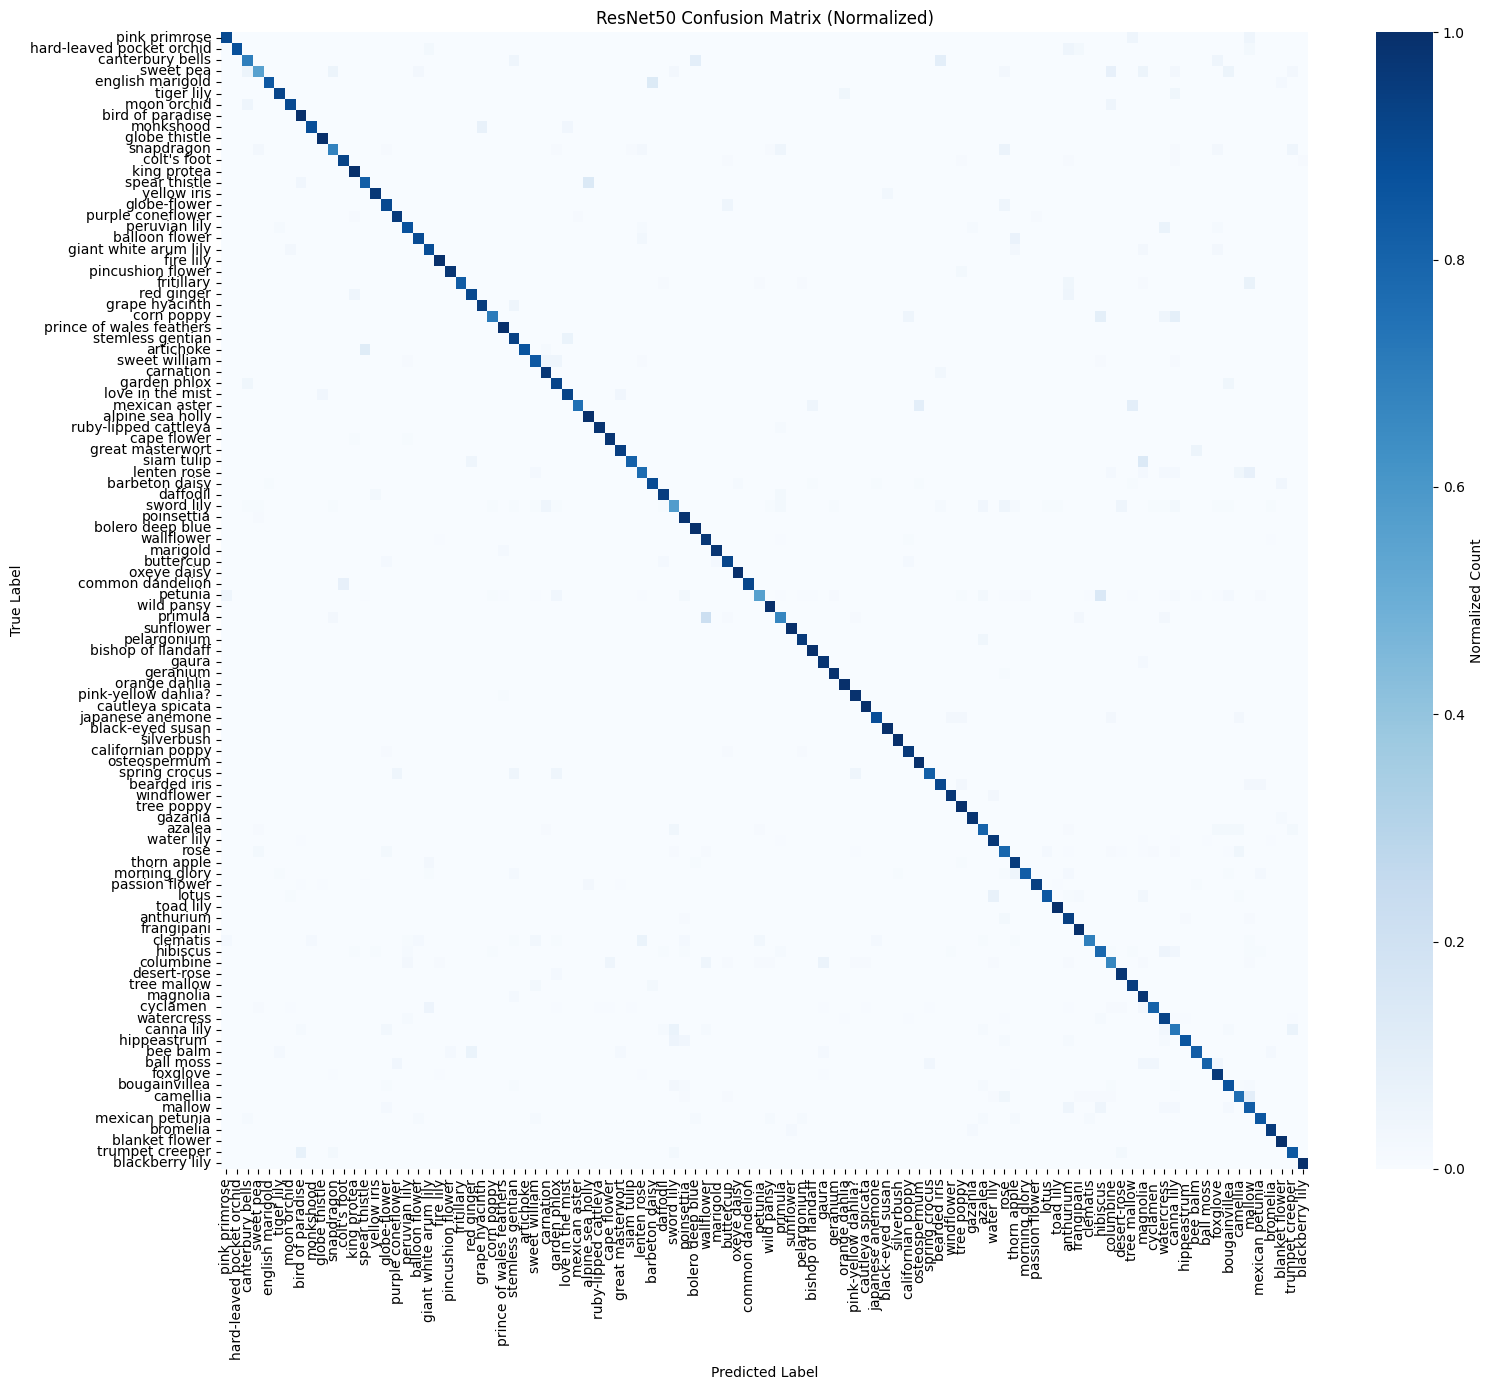

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns # For nicer heatmaps

def plot_confusion_matrix(model, dataloader, class_names, normalize=True, title='Confusion Matrix'):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Generating Confusion Matrix"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = title + ' (Normalized)'

    plt.figure(figsize=(16, 14)) # Adjust figure size for 102 classes
    sns.heatmap(cm, annot=False, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized Count' if normalize else 'Count'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# NOTE: For 102 classes, the confusion matrix will be very dense.
# You might want to zoom in or only plot a subset if it's unreadable.
# Setting annot=False is crucial for readability with many classes.

print("\n--- Confusion Matrix for ResNet18 (Test Set) ---")
plot_confusion_matrix(model_resnet18_trained, dataloaders['test'], class_names, normalize=True, title='ResNet18 Confusion Matrix')

print("\n--- Confusion Matrix for ResNet50 (Test Set) ---")
plot_confusion_matrix(model_resnet50_trained, dataloaders['test'], class_names, normalize=True, title='ResNet50 Confusion Matrix')

In [ ]:
# Assuming you have loaded and trained ResNet-18 and ResNet-50 models
# and captured their training history in variables like:
# resnet18_train_losses, resnet18_train_accuracies, resnet18_val_losses, resnet18_val_accuracies
# resnet50_train_losses, resnet50_train_accuracies, resnet50_val_losses, resnet50_val_accuracies

# Make sure the 'plot_training_history' function definition is present in your script.
# (It's already in the comprehensive code I provided previously).

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = range(len(train_losses))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{model_name} Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- Where to place the code for ResNet-18 ---
# AFTER you have called train_model for ResNet-18 and stored its outputs
# For example, if you had a training block like this:
# model_resnet18_trained, resnet18_train_losses, resnet18_train_accuracies, resnet18_val_losses, resnet18_val_accuracies = train_model(...)

print("\n--- Plotting Training History for ResNet-18 ---")
plot_training_history(
    resnet18_train_losses,
    resnet18_val_losses,
    resnet18_train_accuracies,
    resnet18_val_accuracies,
    "ResNet-18"
)

# --- Where to place the code for ResNet-50 ---
# Similarly, AFTER you have called train_model for ResNet-50 and stored its outputs
# For example, if you had a training block like this:
# model_resnet50_trained, resnet50_train_losses, resnet50_train_accuracies, resnet50_val_losses, resnet50_val_accuracies = train_model(...)

print("\n--- Plotting Training History for ResNet-50 ---")
plot_training_history(
    resnet50_train_losses,
    resnet50_val_losses,
    resnet50_train_accuracies,
    resnet50_val_accuracies,
    "ResNet-50"
)


--- Plotting Training History for ResNet-18 ---


NameError: name 'resnet18_train_losses' is not defined

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class names (provided earlier)
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

# Data transformations (same as before, as input size is 224x224)
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]
IMG_SIZE = 200

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE), # Resize and crop to 200x200
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(int(IMG_SIZE * 1.1)), # Resize slightly larger than IMG_SIZE
        transforms.CenterCrop(IMG_SIZE),      # Then center crop to IMG_SIZE
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(int(IMG_SIZE * 1.1)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
}

data_dir = './data/oxford_flowers102'



Using device: cuda:0


In [ ]:
image_datasets = {
    'train': datasets.Flowers102(root=data_dir, split='train', download=True, transform=data_transforms['train']),
    'val': datasets.Flowers102(root=data_dir, split='val', download=True, transform=data_transforms['val']),
    'test': datasets.Flowers102(root=data_dir, split='test', download=True, transform=data_transforms['test']),
}
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
num_classes = len(class_names)

print(f"Number of training images: {dataset_sizes['train']}")
print(f"Number of validation images: {dataset_sizes['val']}")
print(f"Number of test images: {dataset_sizes['test']}")
print(f"Number of classes: {num_classes}")

# Optional: Visualize a few images
def imshow_unnormalized(inp, title=None):
    """Imshow for a Tensor, unnormalizing it first."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = inp * np.array(normalize_std) + np.array(normalize_mean)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

Number of training images: 1020
Number of validation images: 1020
Number of test images: 6149
Number of classes: 102


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            # Layer 1: Conv (32 filters)
            nn.Conv2d(3, 32, kernel_size=3, padding='same'), # Input: 3x200x200, Output: 32x200x200
            nn.ReLU(),
            # Layer 2: MaxPool (2x2)
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 32x100x100

            # Layer 3: Conv (64 filters)
            nn.Conv2d(32, 64, kernel_size=3, padding='same'), # Output: 64x100x100
            nn.ReLU(),
            # Layer 4: MaxPool (2x2)
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 64x50x50

            # Layer 5: Conv (128 filters)
            nn.Conv2d(64, 128, kernel_size=3, padding='same'), # Output: 128x50x50
            nn.ReLU(),
            # Layer 6: Conv (256 filters)
            nn.Conv2d(128, 256, kernel_size=3, padding='same'), # Output: 256x50x50
            nn.ReLU(),
            # Layer 7: MaxPool (2x2)
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 256x25x25
        )
        # Global Average Pooling Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Output: 256x1x1

        # Classifier (Fully Connected Layers)
        self.classifier = nn.Sequential(
            nn.Flatten(), # Flattens 256x1x1 to 256
            # Fully Connected 1 (256 neurons)
            nn.Linear(256, 256), # Input will be 256 from avgpool
            nn.ReLU(),
            nn.Dropout(0.5),

            # Fully Connected 2 (128 neurons)
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            # Output Layer (102 neurons, Softmax implicitly handled by CrossEntropyLoss)
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else: # phase == 'val'
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
def evaluate_model_full_metrics(model, dataloader, class_names, phase='test'):
    model.eval()
    all_labels = []
    all_preds = []
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    print(f"\n--- Evaluating on {phase} set for full metrics ---")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Evaluating {phase} (metrics)"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = running_loss / len(all_labels)
    overall_accuracy = accuracy_score(all_labels, all_preds)

    print(f'{phase} Loss: {avg_loss:.4f} Overall Accuracy: {overall_accuracy:.4f}')

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(len(class_names))
    )

    print("\n--- Per-Class Metrics ---")
    print(f"{'Class':<30} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 65)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<30} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1_score[i]:<10.4f}")

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro'
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    print("\n--- Aggregated Metrics ---")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall:    {recall_macro:.4f}")
    print(f"Macro F1-Score:  {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}")
    print(f"Weighted Recall:    {recall_weighted:.4f}")
    print(f"Weighted F1-Score:  {f1_weighted:.4f}")

    return overall_accuracy, avg_loss, precision, recall, f1_score, precision_macro, recall_macro, f1_macro, precision_weighted, recall_weighted, f1_weighted


In [ ]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = range(len(train_losses))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{model_name} Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_predictions(model, dataloader, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far < num_images:
                    images_so_far += 1
                    ax = fig.add_subplot(num_images // 3, 3, images_so_far, xticks=[], yticks=[])
                    ax.axis('off')

                    img_to_show = inputs.cpu().data[j]
                    true_label = class_names[labels[j]]
                    pred_label = class_names[preds[j]]

                    title_color = "green" if pred_label == true_label else "red"
                    ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=title_color)

                    imshow_unnormalized(img_to_show)

                else:
                    break
            if images_so_far == num_images:
                break
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, dataloader, class_names, normalize=True, title='Confusion Matrix'):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Generating Confusion Matrix"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = title + ' (Normalized)'

    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=False, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized Count' if normalize else 'Count'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
print("\n--- Training Custom CNN with specified architecture ---")
model_cnn = CustomCNN(num_classes=num_classes).to(device) # Instantiate our custom CNN

criterion_cnn = nn.CrossEntropyLoss()
# Set learning rate to 0.0001 and add L2 regularization (weight_decay)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.1, weight_decay=0.0001) # L2 regularization
exp_lr_scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)

# Train the Custom CNN and capture history
# Note: Increased epochs to 50, as training from scratch often requires more
model_cnn_trained, cnn_train_losses, cnn_train_accuracies, cnn_val_losses, cnn_val_accuracies = train_model(
    model_cnn,
    criterion_cnn,
    optimizer_cnn,
    exp_lr_scheduler_cnn,
    num_epochs=50 # Often needs more epochs for training from scratch
)

torch.save(model_cnn_trained.state_dict(), 'custom_cnn_oxford_flowers102_v2.pth') # Changed filename
print("Custom CNN model saved to custom_cnn_oxford_flowers102_v2.pth")

# Plot Custom CNN history
plot_training_history(cnn_train_losses, cnn_val_losses,
                      cnn_train_accuracies, cnn_val_accuracies,
                      "Custom CNN (Specified Arch)")

# --- Final Evaluation for Custom CNN ---
print("\n--- Final Evaluation for Custom CNN on Test Set ---")
cnn_metrics = evaluate_model_full_metrics(model_cnn_trained, dataloaders['test'], class_names, phase='test')

print("\n--- Visualizing Custom CNN Predictions ---")
visualize_predictions(model_cnn_trained, dataloaders['test'], class_names, num_images=9)

print("\n--- Confusion Matrix for Custom CNN (Test Set) ---")
plot_confusion_matrix(model_cnn_trained, dataloaders['test'], class_names, normalize=True, title='Custom CNN Confusion Matrix')


--- Training Custom CNN with specified architecture ---
Epoch 0/49
----------


train Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  6.02it/s]


train Loss: 60183.9283 Acc: 0.0088


val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  6.06it/s]


val Loss: 4.6511 Acc: 0.0098

Epoch 1/49
----------


train Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 1: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]


train Loss: 5.1298 Acc: 0.0088


val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 1: 100%|██████████| 32/32 [00:06<00:00,  5.07it/s]


val Loss: 4.6331 Acc: 0.0098

Epoch 2/49
----------


train Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 2: 100%|██████████| 32/32 [00:04<00:00,  7.28it/s]


train Loss: 440.4091 Acc: 0.0069


val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  5.13it/s]


val Loss: 4.6307 Acc: 0.0098

Epoch 3/49
----------


train Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 3: 100%|██████████| 32/32 [00:04<00:00,  6.45it/s]


train Loss: 6.1789 Acc: 0.0029


val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


val Loss: 4.6292 Acc: 0.0098

Epoch 4/49
----------


train Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 4: 100%|██████████| 32/32 [00:04<00:00,  6.49it/s]


train Loss: 4.8086 Acc: 0.0039


val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 4: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]


val Loss: 4.6286 Acc: 0.0098

Epoch 5/49
----------


train Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 5:  41%|████      | 13/32 [00:03<00:04,  3.88it/s]


KeyboardInterrupt: 

In [ ]:
def visualize_predictions(model, dataloader, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far < num_images:
                    images_so_far += 1
                    ax = fig.add_subplot(num_images // 3, 3, images_so_far, xticks=[], yticks=[])
                    ax.axis('off')

                    img_to_show = inputs.cpu().data[j]
                    true_label = class_names[labels[j]]
                    pred_label = class_names[preds[j]]

                    title_color = "green" if pred_label == true_label else "red"
                    ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=title_color)

                    imshow_unnormalized(img_to_show)

                else:
                    break
            if images_so_far == num_images:
                break
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(model, dataloader, class_names, normalize=True, title='Confusion Matrix'):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Generating Confusion Matrix"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = title + ' (Normalized)'

    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=False, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized Count' if normalize else 'Count'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()



--- Training Custom CNN ---
Epoch 0/29
----------


train Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 0: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s]


train Loss: 10.2602 Acc: 0.0196


val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 0: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s]


val Loss: 5.9930 Acc: 0.0324

Epoch 1/29
----------


train Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]


train Loss: 6.3226 Acc: 0.0196


val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 1: 100%|██████████| 32/32 [00:06<00:00,  4.68it/s]


val Loss: 4.5761 Acc: 0.0343

Epoch 2/29
----------


train Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 2: 100%|██████████| 32/32 [00:05<00:00,  6.06it/s]


train Loss: 4.8519 Acc: 0.0265


val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


val Loss: 4.3935 Acc: 0.0431

Epoch 3/29
----------


train Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  6.19it/s]


train Loss: 4.6696 Acc: 0.0314


val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 3: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


val Loss: 4.3990 Acc: 0.0363

Epoch 4/29
----------


train Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 4: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]


train Loss: 4.5461 Acc: 0.0235


val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


val Loss: 4.2854 Acc: 0.0451

Epoch 5/29
----------


train Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 5: 100%|██████████| 32/32 [00:05<00:00,  6.01it/s]


train Loss: 4.4823 Acc: 0.0255


val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 5: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s]


val Loss: 4.2471 Acc: 0.0549

Epoch 6/29
----------


train Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]


train Loss: 4.4004 Acc: 0.0441


val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 6: 100%|██████████| 32/32 [00:06<00:00,  4.72it/s]


val Loss: 4.2447 Acc: 0.0461

Epoch 7/29
----------


train Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  5.94it/s]


train Loss: 4.3747 Acc: 0.0392


val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 7: 100%|██████████| 32/32 [00:06<00:00,  4.72it/s]


val Loss: 4.1683 Acc: 0.0422

Epoch 8/29
----------


train Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 8: 100%|██████████| 32/32 [00:05<00:00,  5.91it/s]


train Loss: 4.3205 Acc: 0.0431


val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  5.03it/s]


val Loss: 4.1295 Acc: 0.0529

Epoch 9/29
----------


train Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  5.46it/s]


train Loss: 4.2766 Acc: 0.0431


val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s]


val Loss: 4.0833 Acc: 0.0598

Epoch 10/29
----------


train Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 10: 100%|██████████| 32/32 [00:06<00:00,  5.09it/s]


train Loss: 4.2676 Acc: 0.0480


val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


val Loss: 4.0597 Acc: 0.0657

Epoch 11/29
----------


train Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 11: 100%|██████████| 32/32 [00:06<00:00,  4.82it/s]


train Loss: 4.2228 Acc: 0.0431


val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]


val Loss: 4.0277 Acc: 0.0735

Epoch 12/29
----------


train Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 12: 100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


train Loss: 4.1615 Acc: 0.0578


val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 12: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s]


val Loss: 3.9916 Acc: 0.0735

Epoch 13/29
----------


train Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 13: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s]


train Loss: 4.1377 Acc: 0.0559


val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  5.47it/s]


val Loss: 3.9678 Acc: 0.0775

Epoch 14/29
----------


train Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 14: 100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


train Loss: 4.1058 Acc: 0.0667


val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s]


val Loss: 3.9649 Acc: 0.0745

Epoch 15/29
----------


train Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 15: 100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


train Loss: 4.1797 Acc: 0.0441


val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 15: 100%|██████████| 32/32 [00:05<00:00,  5.53it/s]


val Loss: 3.9678 Acc: 0.0735

Epoch 16/29
----------


train Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  5.43it/s]


train Loss: 4.1330 Acc: 0.0510


val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 16: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s]


val Loss: 3.9580 Acc: 0.0755

Epoch 17/29
----------


train Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 17: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]


train Loss: 4.0898 Acc: 0.0520


val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 17: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


val Loss: 3.9614 Acc: 0.0775

Epoch 18/29
----------


train Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 18: 100%|██████████| 32/32 [00:05<00:00,  5.98it/s]


train Loss: 4.0934 Acc: 0.0676


val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 18: 100%|██████████| 32/32 [00:07<00:00,  4.56it/s]


val Loss: 3.9480 Acc: 0.0735

Epoch 19/29
----------


train Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 19: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]


train Loss: 4.0960 Acc: 0.0647


val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 19: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


val Loss: 3.9405 Acc: 0.0784

Epoch 20/29
----------


train Epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 20: 100%|██████████| 32/32 [00:05<00:00,  6.01it/s]


train Loss: 4.1112 Acc: 0.0627


val Epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 20: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


val Loss: 3.9381 Acc: 0.0755

Epoch 21/29
----------


train Epoch 21:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 21: 100%|██████████| 32/32 [00:05<00:00,  5.46it/s]


train Loss: 4.1092 Acc: 0.0569


val Epoch 21:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 21: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


val Loss: 3.9424 Acc: 0.0775

Epoch 22/29
----------


train Epoch 22:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 22: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


train Loss: 4.0876 Acc: 0.0637


val Epoch 22:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 22: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


val Loss: 3.9383 Acc: 0.0755

Epoch 23/29
----------


train Epoch 23:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 23: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s]


train Loss: 4.1091 Acc: 0.0559


val Epoch 23:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 23: 100%|██████████| 32/32 [00:06<00:00,  4.57it/s]


val Loss: 3.9367 Acc: 0.0765

Epoch 24/29
----------


train Epoch 24:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 24: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


train Loss: 4.1407 Acc: 0.0451


val Epoch 24:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 24: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


val Loss: 3.9336 Acc: 0.0755

Epoch 25/29
----------


train Epoch 25:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 25: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


train Loss: 4.0981 Acc: 0.0549


val Epoch 25:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 25: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s]


val Loss: 3.9377 Acc: 0.0745

Epoch 26/29
----------


train Epoch 26:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 26: 100%|██████████| 32/32 [00:06<00:00,  5.23it/s]


train Loss: 4.1487 Acc: 0.0598


val Epoch 26:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 26: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s]


val Loss: 3.9365 Acc: 0.0735

Epoch 27/29
----------


train Epoch 27:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 27: 100%|██████████| 32/32 [00:06<00:00,  4.83it/s]


train Loss: 4.1036 Acc: 0.0627


val Epoch 27:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 27: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s]


val Loss: 3.9361 Acc: 0.0755

Epoch 28/29
----------


train Epoch 28:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 28: 100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


train Loss: 4.1215 Acc: 0.0490


val Epoch 28:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 28: 100%|██████████| 32/32 [00:05<00:00,  5.46it/s]


val Loss: 3.9357 Acc: 0.0735

Epoch 29/29
----------


train Epoch 29:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 29: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s]


train Loss: 4.1413 Acc: 0.0569


val Epoch 29:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 29: 100%|██████████| 32/32 [00:05<00:00,  5.55it/s]


val Loss: 3.9353 Acc: 0.0755

Training complete in 6m 7s
Best val Acc: 0.0784
Custom CNN model saved to custom_cnn_oxford_flowers102.pth


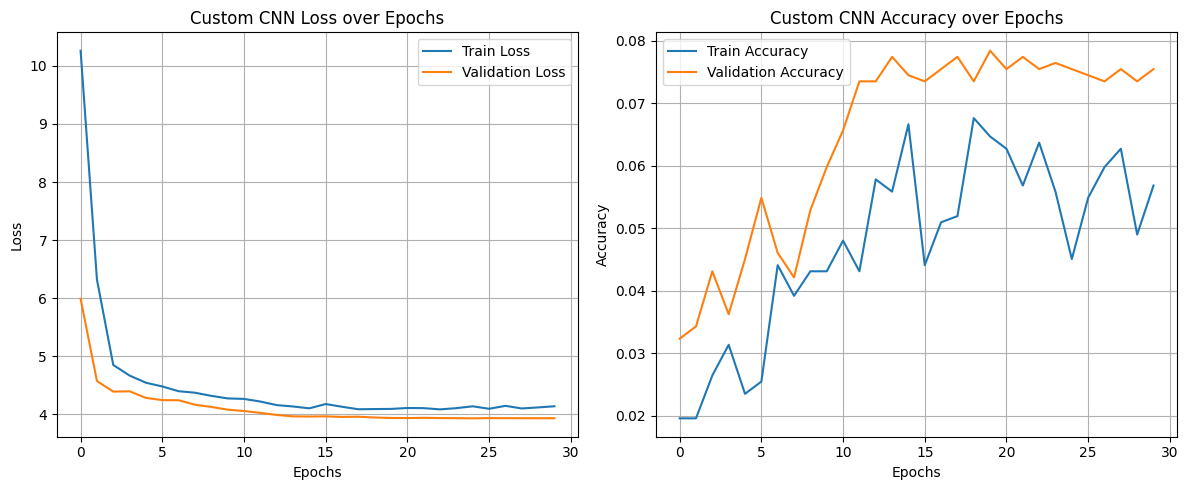


--- Final Evaluation for Custom CNN on Test Set ---

--- Evaluating on test set for full metrics ---


Evaluating test (metrics):   0%|          | 0/193 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating test (metrics): 100%|██████████| 193/193 [00:36<00:00,  5.29it/s]


test Loss: 4.0440 Overall Accuracy: 0.0698

--- Per-Class Metrics ---
Class                          Precision  Recall     F1-Score  
-----------------------------------------------------------------
pink primrose                  0.0000     0.0000     0.0000    
hard-leaved pocket orchid      0.0474     0.8500     0.0898    
canterbury bells               0.0000     0.0000     0.0000    
sweet pea                      0.0377     0.0556     0.0449    
english marigold               0.0696     0.2444     0.1084    
tiger lily                     0.0238     0.0400     0.0299    
moon orchid                    0.0000     0.0000     0.0000    
bird of paradise               0.1000     0.0154     0.0267    
monkshood                      0.0000     0.0000     0.0000    
globe thistle                  0.0000     0.0000     0.0000    
snapdragon                     0.0000     0.0000     0.0000    
colt's foot                    0.0924     0.1642     0.1183    
king protea                    0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/uti

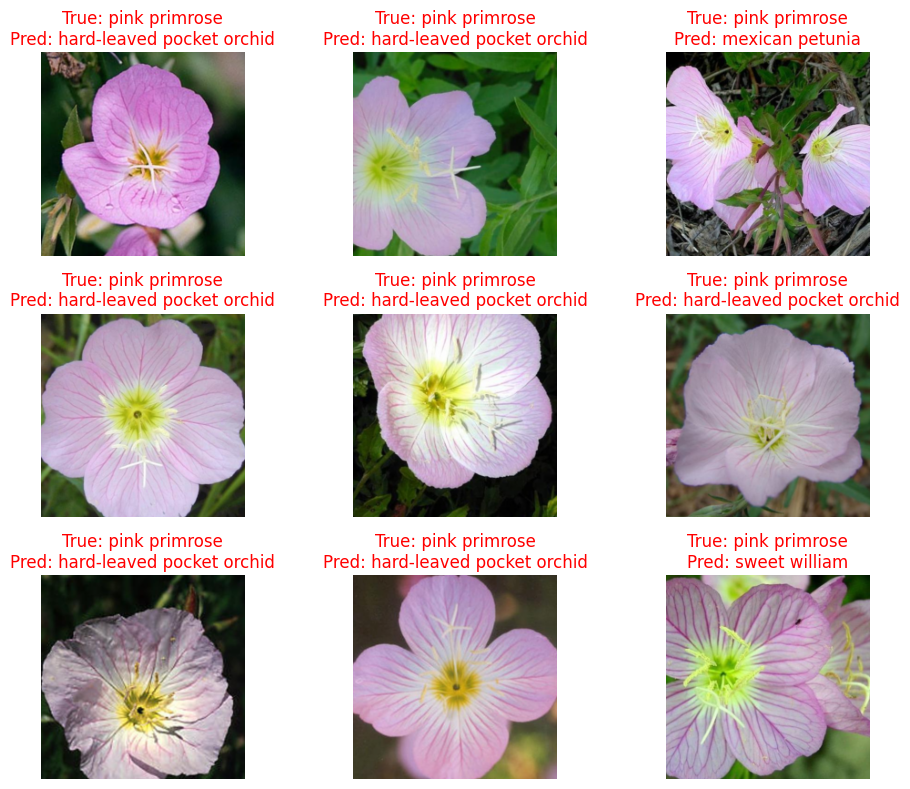


--- Confusion Matrix for Custom CNN (Test Set) ---


Generating Confusion Matrix:   0%|          | 0/193 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Generating Confusion Matrix: 100%|██████████| 193/193 [00:37<00:00,  5.09it/s]


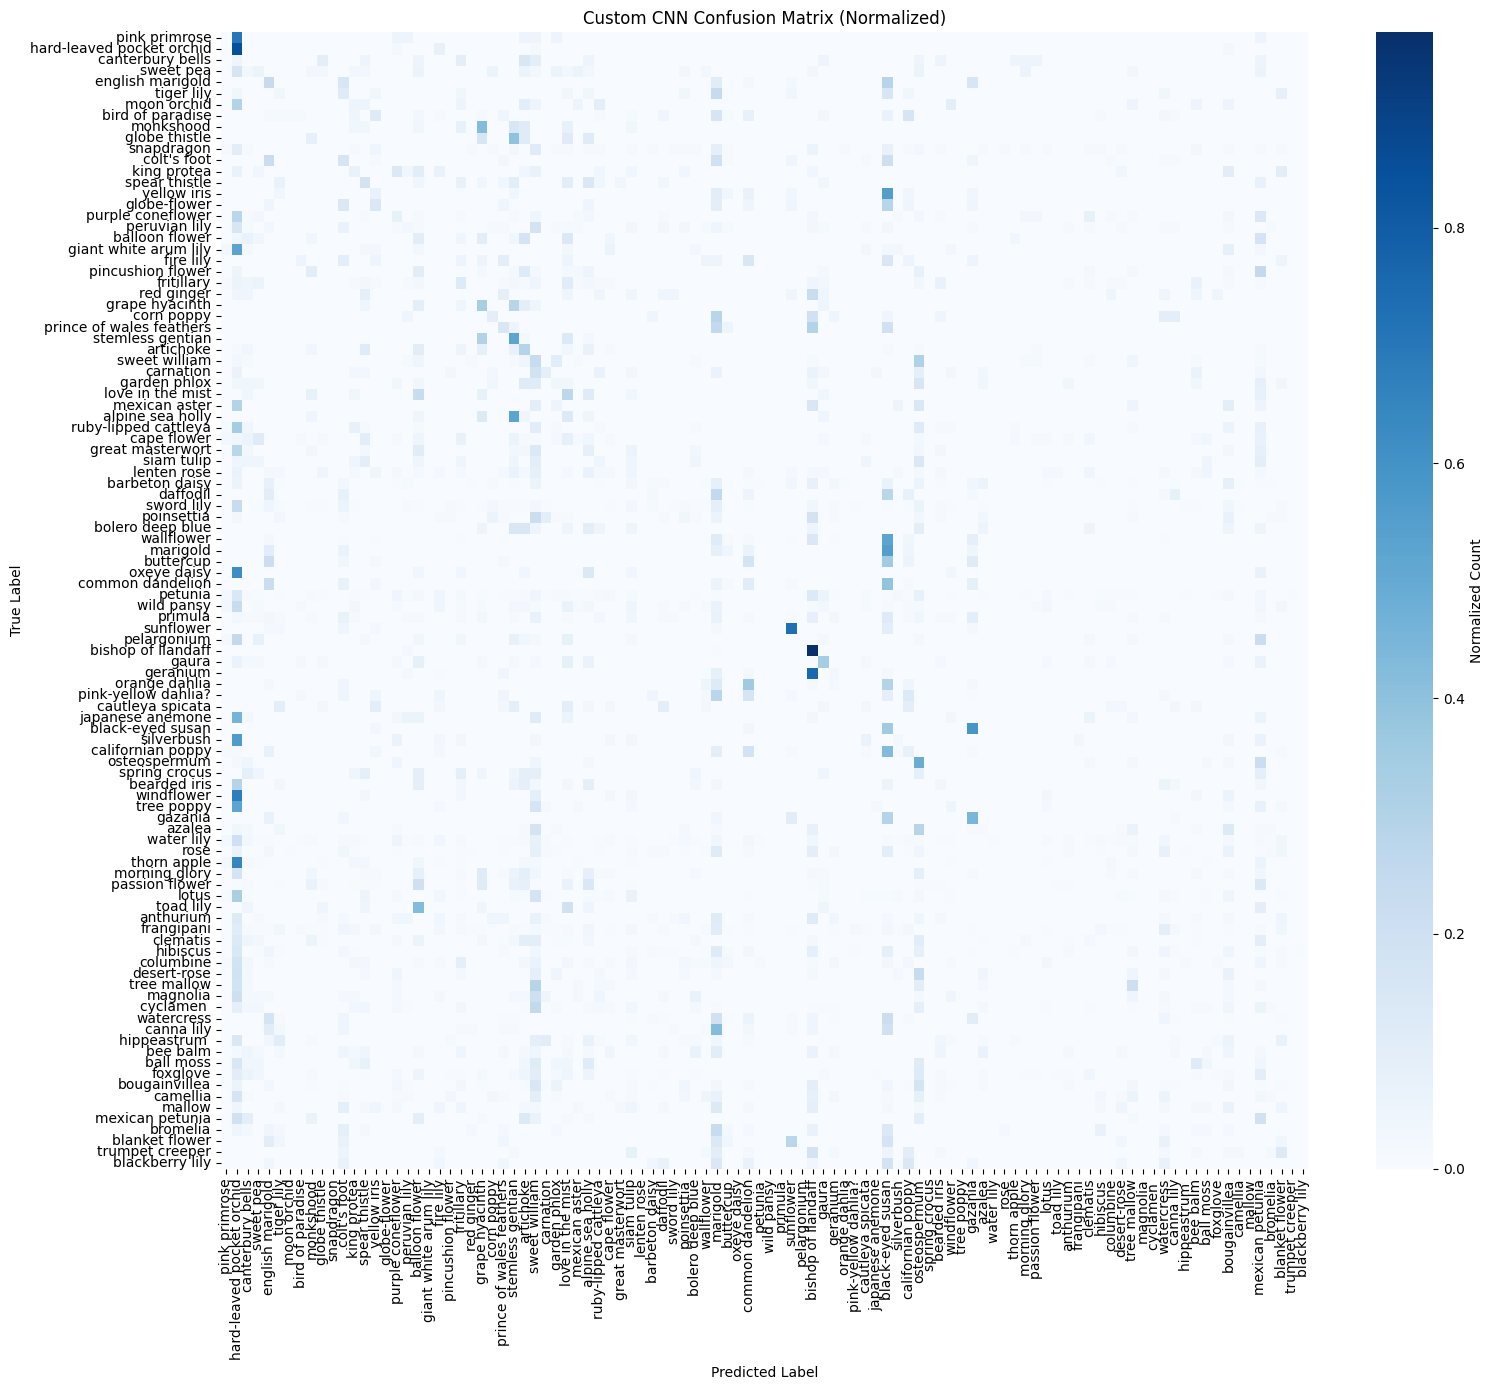

In [ ]:
print("\n--- Training Custom CNN ---")
model_cnn = CustomCNN(num_classes=num_classes).to(device) # Instantiate our custom CNN

criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001) # Start with a common learning rate
exp_lr_scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)

# Train the Custom CNN and capture history
model_cnn_trained, cnn_train_losses, cnn_train_accuracies, cnn_val_losses, cnn_val_accuracies = train_model(
    model_cnn,
    criterion_cnn,
    optimizer_cnn,
    exp_lr_scheduler_cnn,
    num_epochs=30 # Often need more epochs for training from scratch
)

torch.save(model_cnn_trained.state_dict(), 'custom_cnn_oxford_flowers102.pth')
print("Custom CNN model saved to custom_cnn_oxford_flowers102.pth")

# Plot Custom CNN history
plot_training_history(cnn_train_losses, cnn_val_losses,
                      cnn_train_accuracies, cnn_val_accuracies,
                      "Custom CNN")

# --- Final Evaluation for Custom CNN ---
print("\n--- Final Evaluation for Custom CNN on Test Set ---")
cnn_metrics = evaluate_model_full_metrics(model_cnn_trained, dataloaders['test'], class_names, phase='test')

print("\n--- Visualizing Custom CNN Predictions ---")
visualize_predictions(model_cnn_trained, dataloaders['test'], class_names, num_images=9)

print("\n--- Confusion Matrix for Custom CNN (Test Set) ---")
plot_confusion_matrix(model_cnn_trained, dataloaders['test'], class_names, normalize=True, title='Custom CNN Confusion Matrix')

In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class names (provided earlier)
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

# Data transformations - AlexNet typically expects 224x224 input
# If you are using the original AlexNet architecture without modifications to its first conv layer,
# it expects 224x224 input.
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]
IMG_SIZE = 224 # AlexNet's standard input size

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # Resize slightly larger then crop
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
}

data_dir = './data/oxford_flowers102'

image_datasets = {
    'train': datasets.Flowers102(root=data_dir, split='train', download=True, transform=data_transforms['train']),
    'val': datasets.Flowers102(root=data_dir, split='val', download=True, transform=data_transforms['val']),
    'test': datasets.Flowers102(root=data_dir, split='test', download=True, transform=data_transforms['test']),
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
num_classes = len(class_names)

print(f"Number of training images: {dataset_sizes['train']}")
print(f"Number of validation images: {dataset_sizes['val']}")
print(f"Number of test images: {dataset_sizes['test']}")
print(f"Number of classes: {num_classes}")

# Optional: Visualize a few images

Using device: cuda:0
Number of training images: 1020
Number of validation images: 1020
Number of test images: 6149
Number of classes: 102


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else: # phase == 'val'
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
def evaluate_model_full_metrics(model, dataloader, class_names, phase='test'):
    model.eval()
    all_labels = []
    all_preds = []
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    print(f"\n--- Evaluating on {phase} set for full metrics ---")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Evaluating {phase} (metrics)"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = running_loss / len(all_labels)
    overall_accuracy = accuracy_score(all_labels, all_preds)

    print(f'{phase} Loss: {avg_loss:.4f} Overall Accuracy: {overall_accuracy:.4f}')

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(len(class_names))
    )

    print("\n--- Per-Class Metrics ---")
    print(f"{'Class':<30} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 65)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<30} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1_score[i]:<10.4f}")

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro'
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    print("\n--- Aggregated Metrics ---")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall:    {recall_macro:.4f}")
    print(f"Macro F1-Score:  {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}")
    print(f"Weighted Recall:    {recall_weighted:.4f}")
    print(f"Weighted F1-Score:  {f1_weighted:.4f}")

    return overall_accuracy, avg_loss, precision, recall, f1_score, precision_macro, recall_macro, f1_macro, precision_weighted, recall_weighted, f1_weighted

# --- Plotting function ---

In [ ]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = range(len(train_losses))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{model_name} Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- Visualize Predictions and Confusion Matrix (utility functions) ---
def visualize_predictions(model, dataloader, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far < num_images:
                    images_so_far += 1
                    ax = fig.add_subplot(num_images // 3, 3, images_so_far, xticks=[], yticks=[])
                    ax.axis('off')

                    img_to_show = inputs.cpu().data[j]
                    true_label = class_names[labels[j]]
                    pred_label = class_names[preds[j]]

                    title_color = "green" if pred_label == true_label else "red"
                    ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=title_color)

                    imshow_unnormalized(img_to_show)

                else:
                    break
            if images_so_far == num_images:
                break
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, dataloader, class_names, normalize=True, title='Confusion Matrix'):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Generating Confusion Matrix"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = title + ' (Normalized)'

    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=False, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized Count' if normalize else 'Count'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()




--- Training AlexNet ---


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 93.6MB/s]


Epoch 0/24
----------


train Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s]


train Loss: 4.2176 Acc: 0.0922


val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 0: 100%|██████████| 32/32 [00:06<00:00,  5.08it/s]


val Loss: 2.6579 Acc: 0.3804

Epoch 1/24
----------


train Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 1: 100%|██████████| 32/32 [00:04<00:00,  6.40it/s]


train Loss: 2.2703 Acc: 0.4284


val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 1: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


val Loss: 1.6609 Acc: 0.5755

Epoch 2/24
----------


train Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 2: 100%|██████████| 32/32 [00:05<00:00,  6.07it/s]


train Loss: 1.3826 Acc: 0.6245


val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  4.73it/s]


val Loss: 1.2623 Acc: 0.6559

Epoch 3/24
----------


train Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s]


train Loss: 1.0678 Acc: 0.7088


val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 3: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


val Loss: 1.1206 Acc: 0.6990

Epoch 4/24
----------


train Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 4: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s]


train Loss: 0.8770 Acc: 0.7608


val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  4.68it/s]


val Loss: 1.0642 Acc: 0.7235

Epoch 5/24
----------


train Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 5: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s]


train Loss: 0.6437 Acc: 0.8186


val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 5: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


val Loss: 1.0334 Acc: 0.7353

Epoch 6/24
----------


train Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 6: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s]


train Loss: 0.7014 Acc: 0.8029


val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 6: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


val Loss: 1.0644 Acc: 0.7275

Epoch 7/24
----------


train Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]


train Loss: 0.4891 Acc: 0.8559


val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 7: 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


val Loss: 0.9619 Acc: 0.7529

Epoch 8/24
----------


train Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 8: 100%|██████████| 32/32 [00:05<00:00,  5.97it/s]


train Loss: 0.4051 Acc: 0.8843


val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 8: 100%|██████████| 32/32 [00:05<00:00,  5.43it/s]


val Loss: 0.9272 Acc: 0.7667

Epoch 9/24
----------


train Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 9: 100%|██████████| 32/32 [00:06<00:00,  5.24it/s]


train Loss: 0.3927 Acc: 0.8902


val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s]


val Loss: 0.9029 Acc: 0.7725

Epoch 10/24
----------


train Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 10: 100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


train Loss: 0.3512 Acc: 0.9108


val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


val Loss: 0.9054 Acc: 0.7833

Epoch 11/24
----------


train Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 11: 100%|██████████| 32/32 [00:06<00:00,  5.09it/s]


train Loss: 0.3252 Acc: 0.9069


val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


val Loss: 0.8843 Acc: 0.7775

Epoch 12/24
----------


train Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 12: 100%|██████████| 32/32 [00:06<00:00,  5.27it/s]


train Loss: 0.3570 Acc: 0.9000


val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 12: 100%|██████████| 32/32 [00:05<00:00,  5.45it/s]


val Loss: 0.9046 Acc: 0.7853

Epoch 13/24
----------


train Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s]


train Loss: 0.3016 Acc: 0.9235


val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 13: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


val Loss: 0.9167 Acc: 0.7775

Epoch 14/24
----------


train Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]


train Loss: 0.2890 Acc: 0.9196


val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 14: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


val Loss: 0.9110 Acc: 0.7804

Epoch 15/24
----------


train Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 15: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s]


train Loss: 0.3243 Acc: 0.9098


val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 15: 100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


val Loss: 0.9059 Acc: 0.7814

Epoch 16/24
----------


train Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s]


train Loss: 0.2743 Acc: 0.9167


val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 16: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


val Loss: 0.9012 Acc: 0.7873

Epoch 17/24
----------


train Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 17: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


train Loss: 0.2836 Acc: 0.9304


val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 17: 100%|██████████| 32/32 [00:07<00:00,  4.57it/s]


val Loss: 0.8984 Acc: 0.7863

Epoch 18/24
----------


train Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 18: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s]


train Loss: 0.2965 Acc: 0.9147


val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 18: 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


val Loss: 0.8984 Acc: 0.7892

Epoch 19/24
----------


train Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 19: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]


train Loss: 0.3074 Acc: 0.9284


val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 19: 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


val Loss: 0.8968 Acc: 0.7912

Epoch 20/24
----------


train Epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 20: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s]


train Loss: 0.3131 Acc: 0.9167


val Epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 20: 100%|██████████| 32/32 [00:06<00:00,  4.64it/s]


val Loss: 0.8983 Acc: 0.7922

Epoch 21/24
----------


train Epoch 21:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 21: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]


train Loss: 0.3092 Acc: 0.9147


val Epoch 21:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 21: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s]


val Loss: 0.8985 Acc: 0.7931

Epoch 22/24
----------


train Epoch 22:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 22: 100%|██████████| 32/32 [00:05<00:00,  6.05it/s]


train Loss: 0.2885 Acc: 0.9176


val Epoch 22:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 22: 100%|██████████| 32/32 [00:06<00:00,  5.15it/s]


val Loss: 0.8985 Acc: 0.7931

Epoch 23/24
----------


train Epoch 23:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 23: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


train Loss: 0.2695 Acc: 0.9225


val Epoch 23:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 23: 100%|██████████| 32/32 [00:05<00:00,  5.54it/s]


val Loss: 0.8982 Acc: 0.7931

Epoch 24/24
----------


train Epoch 24:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 24: 100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


train Loss: 0.3080 Acc: 0.9118


val Epoch 24:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 24: 100%|██████████| 32/32 [00:05<00:00,  5.50it/s]


val Loss: 0.8981 Acc: 0.7922

Training complete in 5m 3s
Best val Acc: 0.7931
AlexNet model saved to alexnet_oxford_flowers102.pth


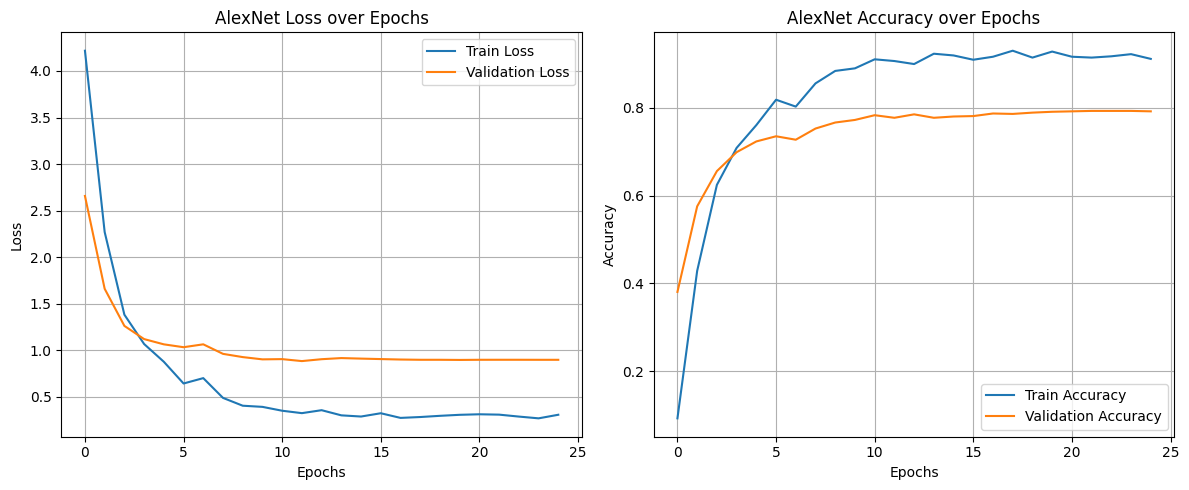

In [ ]:
print("\n--- Training AlexNet ---")

# Load pre-trained AlexNet
# weights=models.AlexNet_Weights.IMAGENET1K_V1 ensures we get the pre-trained version
model_alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# Modify the classifier (fully connected layers) for our number of classes
# AlexNet's classifier is a Sequential module with 3 linear layers.
# The last layer is model_alexnet.classifier[6]
num_ftrs_alexnet = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs_alexnet, num_classes)

model_alexnet = model_alexnet.to(device)

criterion_alexnet = nn.CrossEntropyLoss()
# For transfer learning, a smaller learning rate is often good
optimizer_alexnet = optim.Adam(model_alexnet.parameters(), lr=0.0001)
exp_lr_scheduler_alexnet = lr_scheduler.StepLR(optimizer_alexnet, step_size=7, gamma=0.1)

# Train AlexNet and capture history
# Start with a moderate number of epochs, typically less than training from scratch
model_alexnet_trained, alexnet_train_losses, alexnet_train_accuracies, alexnet_val_losses, alexnet_val_accuracies = train_model(
    model_alexnet,
    criterion_alexnet,
    optimizer_alexnet,
    exp_lr_scheduler_alexnet,
    num_epochs=25 # Can increase if validation accuracy is still improving
)

torch.save(model_alexnet_trained.state_dict(), 'alexnet_oxford_flowers102.pth')
print("AlexNet model saved to alexnet_oxford_flowers102.pth")

# Plot AlexNet history
plot_training_history(alexnet_train_losses, alexnet_val_losses,
                      alexnet_train_accuracies, alexnet_val_accuracies,
                      "AlexNet")




--- Final Evaluation on Test Set with Detailed Metrics for AlexNet ---

--- Evaluating on test set for full metrics ---


Evaluating test (metrics):   0%|          | 0/193 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating test (metrics): 100%|██████████| 193/193 [00:39<00:00,  4.84it/s]


test Loss: 1.1014 Overall Accuracy: 0.7564

--- Per-Class Metrics ---
Class                          Precision  Recall     F1-Score  
-----------------------------------------------------------------
pink primrose                  0.5667     0.8500     0.6800    
hard-leaved pocket orchid      0.8780     0.9000     0.8889    
canterbury bells               0.2727     0.3000     0.2857    
sweet pea                      0.2857     0.2778     0.2817    
english marigold               0.7619     0.7111     0.7356    
tiger lily                     0.9167     0.8800     0.8980    
moon orchid                    0.6207     0.9000     0.7347    
bird of paradise               0.9000     0.9692     0.9333    
monkshood                      0.5714     0.9231     0.7059    
globe thistle                  0.7586     0.8800     0.8148    
snapdragon                     0.6458     0.4627     0.5391    
colt's foot                    0.7763     0.8806     0.8252    
king protea                    0

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


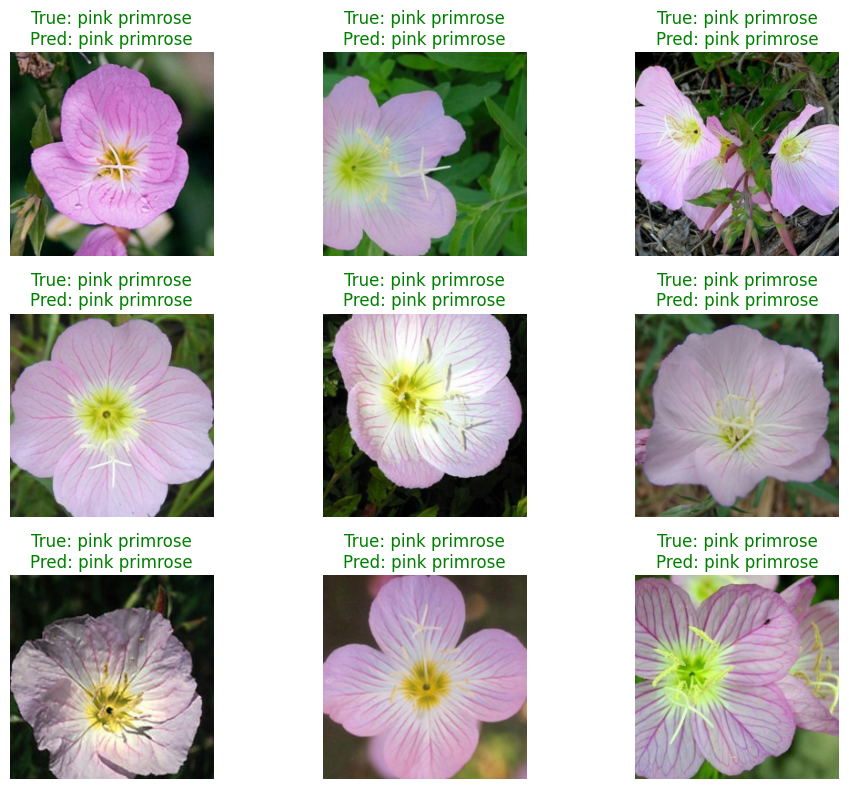


--- Confusion Matrix for AlexNet (Test Set) ---


Generating Confusion Matrix:   0%|          | 0/193 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Generating Confusion Matrix: 100%|██████████| 193/193 [00:37<00:00,  5.13it/s]


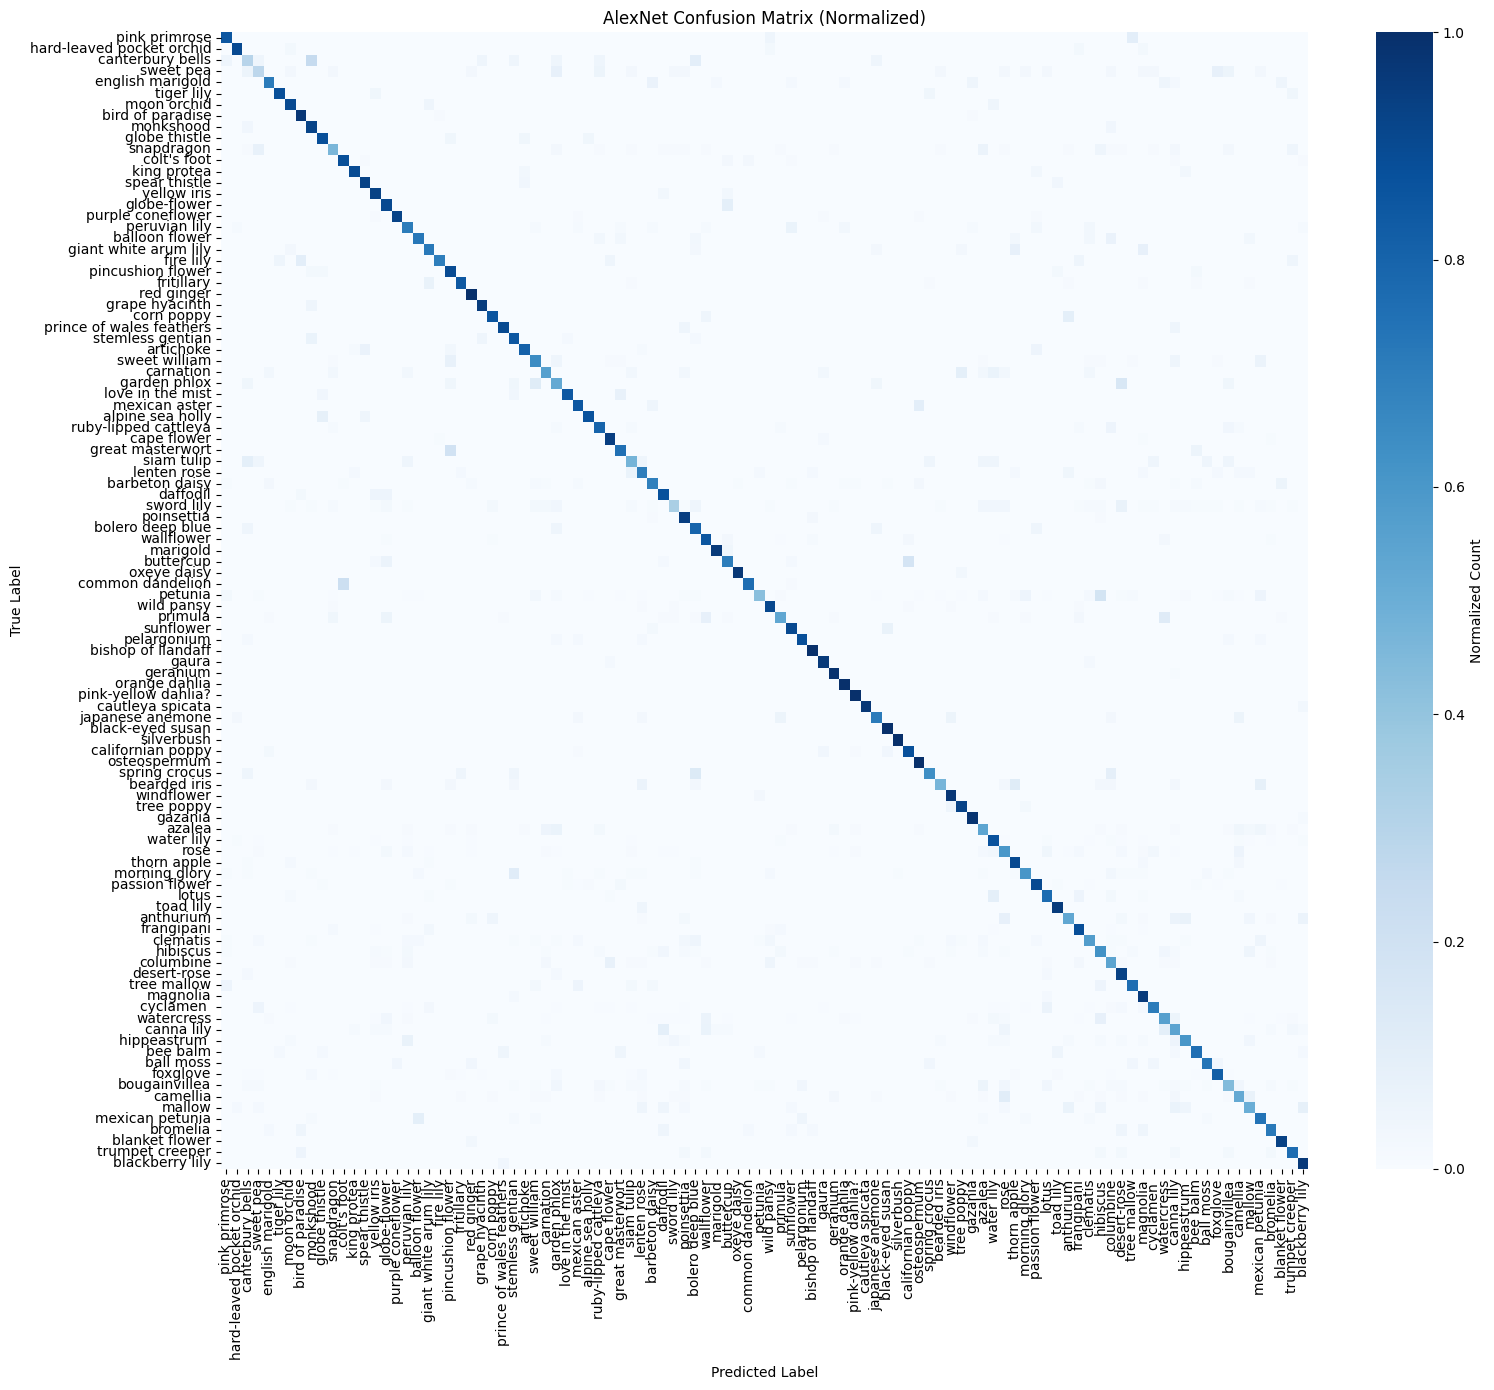

In [ ]:
print("\n--- Final Evaluation on Test Set with Detailed Metrics for AlexNet ---")
alexnet_metrics = evaluate_model_full_metrics(model_alexnet_trained, dataloaders['test'], class_names, phase='test')

# --- Visualize Predictions and Confusion Matrix after metrics ---
print("\n--- Visualizing AlexNet Predictions ---")
visualize_predictions(model_alexnet_trained, dataloaders['test'], class_names, num_images=9)

print("\n--- Confusion Matrix for AlexNet (Test Set) ---")
plot_confusion_matrix(model_alexnet_trained, dataloaders['test'], class_names, normalize=True, title='AlexNet Confusion Matrix')

In [ ]:
torch.save(model_alexnet_trained.state_dict(), 'alexnet_oxford_flowers102.pth')

print("AlexNet model saved to alexnet_oxford_flowers102.pth")

AlexNet model saved to alexnet_oxford_flowers102.pth


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns # For nicer heatmaps

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class names (provided earlier)
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

# Data transformations (as before)
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
}

data_dir = './data/oxford_flowers102'


Using device: cuda:0


In [ ]:
image_datasets = {
    'train': datasets.Flowers102(root=data_dir, split='train', download=True, transform=data_transforms['train']),
    'val': datasets.Flowers102(root=data_dir, split='val', download=True, transform=data_transforms['val']),
    'test': datasets.Flowers102(root=data_dir, split='test', download=True, transform=data_transforms['test']),
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
num_classes = len(class_names)

print(f"Number of training images: {dataset_sizes['train']}")
print(f"Number of validation images: {dataset_sizes['val']}")
print(f"Number of test images: {dataset_sizes['test']}")
print(f"Number of classes: {num_classes}")


Number of training images: 1020
Number of validation images: 1020
Number of test images: 6149
Number of classes: 102


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # History lists
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store history
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item()) # .item() to get scalar from tensor
            else: # phase == 'val'
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item()) # .item() to get scalar from tensor

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

# --- Evaluation Function (reused for test) ---
def evaluate_model_full_metrics(model, dataloader, class_names, phase='test'):
    model.eval()
    all_labels = []
    all_preds = []
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    print(f"\n--- Evaluating on {phase} set for full metrics ---")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Evaluating {phase} (metrics)"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = running_loss / len(all_labels)
    overall_accuracy = accuracy_score(all_labels, all_preds)

    print(f'{phase} Loss: {avg_loss:.4f} Overall Accuracy: {overall_accuracy:.4f}')

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(len(class_names))
    )

    print("\n--- Per-Class Metrics ---")
    print(f"{'Class':<30} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 65)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<30} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1_score[i]:<10.4f}")

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro'
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    print("\n--- Aggregated Metrics ---")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall:    {recall_macro:.4f}")
    print(f"Macro F1-Score:  {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}")
    print(f"Weighted Recall:    {recall_weighted:.4f}")
    print(f"Weighted F1-Score:  {f1_weighted:.4f}")

    return overall_accuracy, avg_loss, precision, recall, f1_score, precision_macro, recall_macro, f1_macro, precision_weighted, recall_weighted, f1_weighted


In [ ]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = range(len(train_losses))

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{model_name} Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()




--- Training ResNet18 ---


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.7MB/s]


Epoch 0/14
----------


train Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 0: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


train Loss: 4.0012 Acc: 0.1412


val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]


val Loss: 3.3075 Acc: 0.2461

Epoch 1/14
----------


train Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


train Loss: 2.4577 Acc: 0.3853


val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s]


val Loss: 1.9609 Acc: 0.4745

Epoch 2/14
----------


train Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 2: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]


train Loss: 1.7594 Acc: 0.5637


val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  4.82it/s]


val Loss: 2.4016 Acc: 0.4402

Epoch 3/14
----------


train Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s]


train Loss: 1.4785 Acc: 0.6235


val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 3: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]


val Loss: 1.7084 Acc: 0.5490

Epoch 4/14
----------


train Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  5.04it/s]


train Loss: 1.1636 Acc: 0.6971


val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  4.75it/s]


val Loss: 1.4475 Acc: 0.6127

Epoch 5/14
----------


train Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 5: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]


train Loss: 1.0592 Acc: 0.7196


val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 5: 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]


val Loss: 1.5379 Acc: 0.6235

Epoch 6/14
----------


train Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s]


train Loss: 0.9101 Acc: 0.7618


val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 6: 100%|██████████| 32/32 [00:06<00:00,  4.69it/s]


val Loss: 1.3964 Acc: 0.6382

Epoch 7/14
----------


train Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s]


train Loss: 0.6043 Acc: 0.8598


val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 7: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s]


val Loss: 0.6283 Acc: 0.8343

Epoch 8/14
----------


train Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 8: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s]


train Loss: 0.4790 Acc: 0.9000


val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


val Loss: 0.5597 Acc: 0.8569

Epoch 9/14
----------


train Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  6.07it/s]


train Loss: 0.4096 Acc: 0.9127


val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  5.51it/s]


val Loss: 0.5413 Acc: 0.8598

Epoch 10/14
----------


train Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  5.50it/s]


train Loss: 0.3229 Acc: 0.9363


val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s]


val Loss: 0.5240 Acc: 0.8667

Epoch 11/14
----------


train Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 11: 100%|██████████| 32/32 [00:06<00:00,  5.18it/s]


train Loss: 0.3091 Acc: 0.9471


val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


val Loss: 0.5147 Acc: 0.8676

Epoch 12/14
----------


train Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 12: 100%|██████████| 32/32 [00:06<00:00,  5.16it/s]


train Loss: 0.3237 Acc: 0.9353


val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 12: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


val Loss: 0.5040 Acc: 0.8716

Epoch 13/14
----------


train Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]


train Loss: 0.2752 Acc: 0.9441


val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


val Loss: 0.4991 Acc: 0.8706

Epoch 14/14
----------


train Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s]


train Loss: 0.2692 Acc: 0.9461


val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 14: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s]


val Loss: 0.4798 Acc: 0.8775

Training complete in 2m 58s
Best val Acc: 0.8775
ResNet18 model saved to resnet18_oxford_flowers102.pth


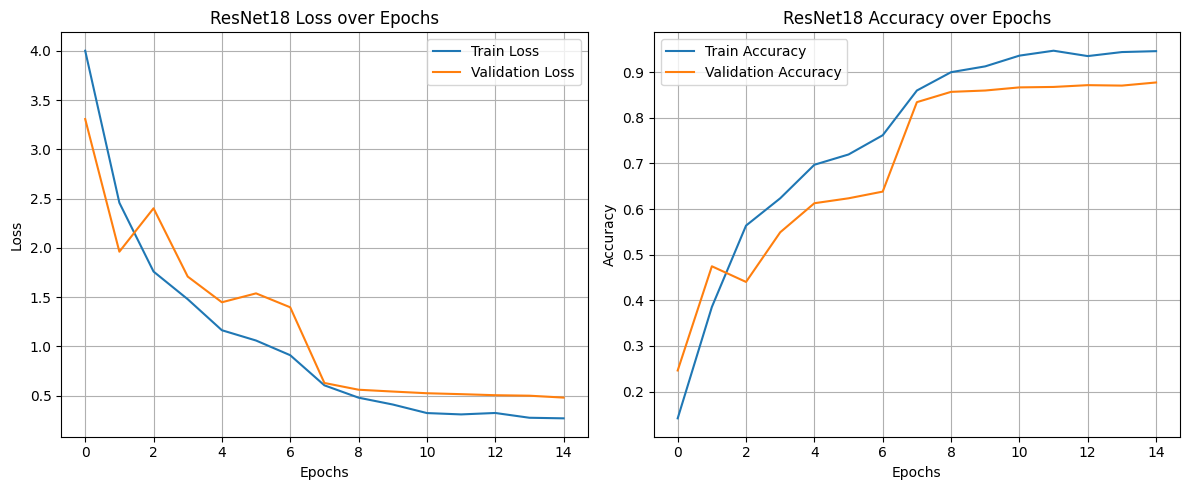

In [ ]:
print("\n--- Training ResNet18 ---")
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs_resnet18 = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs_resnet18, num_classes)
model_resnet18 = model_resnet18.to(device)

criterion_resnet18 = nn.CrossEntropyLoss()
optimizer_resnet18 = optim.Adam(model_resnet18.parameters(), lr=0.001)
exp_lr_scheduler_resnet18 = lr_scheduler.StepLR(optimizer_resnet18, step_size=7, gamma=0.1)

# Capture history
model_resnet18_trained, resnet18_train_losses, resnet18_train_accuracies, resnet18_val_losses, resnet18_val_accuracies = train_model(
    model_resnet18,
    criterion_resnet18,
    optimizer_resnet18,
    exp_lr_scheduler_resnet18,
    num_epochs=15
)
torch.save(model_resnet18_trained.state_dict(), 'resnet18_oxford_flowers102.pth')
print("ResNet18 model saved to resnet18_oxford_flowers102.pth")

# Plot ResNet18 history
plot_training_history(resnet18_train_losses, resnet18_val_losses,
                      resnet18_train_accuracies, resnet18_val_accuracies,
                      "ResNet18")


--- Training ResNet50 ---


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


Epoch 0/14
----------


train Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 0: 100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


train Loss: 3.9518 Acc: 0.1618


val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s]


val Loss: 3.4667 Acc: 0.2843

Epoch 1/14
----------


train Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 1: 100%|██████████| 32/32 [00:10<00:00,  2.95it/s]


train Loss: 1.9858 Acc: 0.5000


val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 1: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


val Loss: 1.9215 Acc: 0.5196

Epoch 2/14
----------


train Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 2: 100%|██████████| 32/32 [00:10<00:00,  3.10it/s]


train Loss: 1.3303 Acc: 0.6539


val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s]


val Loss: 1.2989 Acc: 0.6284

Epoch 3/14
----------


train Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 3: 100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


train Loss: 0.9137 Acc: 0.7686


val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 3: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s]


val Loss: 1.4400 Acc: 0.6696

Epoch 4/14
----------


train Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 4: 100%|██████████| 32/32 [00:10<00:00,  2.95it/s]


train Loss: 0.7024 Acc: 0.8020


val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 4: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]


val Loss: 1.0020 Acc: 0.7539

Epoch 5/14
----------


train Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 5: 100%|██████████| 32/32 [00:10<00:00,  3.09it/s]


train Loss: 0.5890 Acc: 0.8353


val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 5: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s]


val Loss: 0.9665 Acc: 0.7431

Epoch 6/14
----------


train Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 6: 100%|██████████| 32/32 [00:10<00:00,  3.03it/s]


train Loss: 0.6097 Acc: 0.8353


val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 6: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


val Loss: 1.1459 Acc: 0.7343

Epoch 7/14
----------


train Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 7: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


train Loss: 0.4882 Acc: 0.8833


val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 7: 100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


val Loss: 0.5687 Acc: 0.8480

Epoch 8/14
----------


train Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 8: 100%|██████████| 32/32 [00:10<00:00,  3.03it/s]


train Loss: 0.2840 Acc: 0.9265


val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  5.24it/s]


val Loss: 0.5022 Acc: 0.8667

Epoch 9/14
----------


train Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 9: 100%|██████████| 32/32 [00:10<00:00,  2.96it/s]


train Loss: 0.2468 Acc: 0.9422


val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 9: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]


val Loss: 0.4743 Acc: 0.8784

Epoch 10/14
----------


train Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 10: 100%|██████████| 32/32 [00:10<00:00,  3.08it/s]


train Loss: 0.1977 Acc: 0.9549


val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 10: 100%|██████████| 32/32 [00:06<00:00,  5.24it/s]


val Loss: 0.4510 Acc: 0.8804

Epoch 11/14
----------


train Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 11: 100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


train Loss: 0.1786 Acc: 0.9578


val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 11: 100%|██████████| 32/32 [00:06<00:00,  5.29it/s]


val Loss: 0.4346 Acc: 0.8833

Epoch 12/14
----------


train Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 12: 100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


train Loss: 0.1704 Acc: 0.9657


val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 12: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


val Loss: 0.4220 Acc: 0.8833

Epoch 13/14
----------


train Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 13: 100%|██████████| 32/32 [00:10<00:00,  3.02it/s]


train Loss: 0.1372 Acc: 0.9735


val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s]


val Loss: 0.4101 Acc: 0.8912

Epoch 14/14
----------


train Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train Epoch 14: 100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


train Loss: 0.1656 Acc: 0.9608


val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val Epoch 14: 100%|██████████| 32/32 [00:06<00:00,  4.91it/s]


val Loss: 0.4196 Acc: 0.8863

Training complete in 4m 19s
Best val Acc: 0.8912
ResNet50 model saved to resnet50_oxford_flowers102.pth


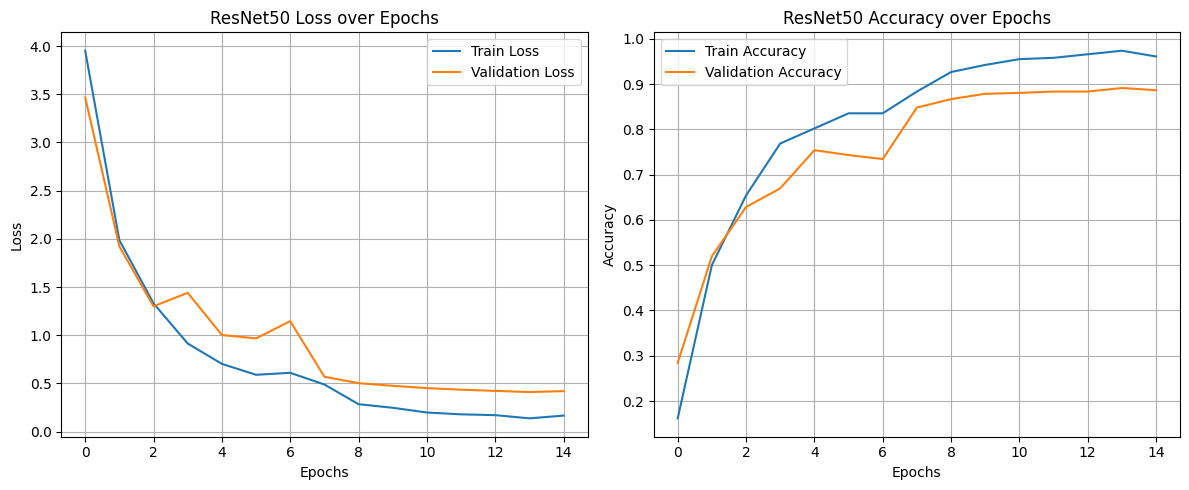


--- Final Evaluation on Test Set with Detailed Metrics ---

--- ResNet18 Detailed Metrics ---

--- Evaluating on test set for full metrics ---


Evaluating test (metrics):   0%|          | 0/193 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating test (metrics): 100%|██████████| 193/193 [00:34<00:00,  5.55it/s]


test Loss: 0.5910 Overall Accuracy: 0.8499

--- Per-Class Metrics ---
Class                          Precision  Recall     F1-Score  
-----------------------------------------------------------------
pink primrose                  0.6296     0.8500     0.7234    
hard-leaved pocket orchid      0.9459     0.8750     0.9091    
canterbury bells               0.4062     0.6500     0.5000    
sweet pea                      0.7391     0.4722     0.5763    
english marigold               0.8000     0.7111     0.7529    
tiger lily                     1.0000     0.9600     0.9796    
moon orchid                    0.9048     0.9500     0.9268    
bird of paradise               0.9559     1.0000     0.9774    
monkshood                      0.5750     0.8846     0.6970    
globe thistle                  0.9524     0.8000     0.8696    
snapdragon                     0.7656     0.7313     0.7481    
colt's foot                    0.9254     0.9254     0.9254    
king protea                    0

Evaluating test (metrics):   0%|          | 0/193 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating test (metrics): 100%|██████████| 193/193 [00:38<00:00,  5.05it/s]

test Loss: 0.4926 Overall Accuracy: 0.8784

--- Per-Class Metrics ---
Class                          Precision  Recall     F1-Score  
-----------------------------------------------------------------
pink primrose                  0.6129     0.9500     0.7451    
hard-leaved pocket orchid      1.0000     0.9250     0.9610    
canterbury bells               0.5000     0.5000     0.5000    
sweet pea                      0.5000     0.5000     0.5000    
english marigold               0.8913     0.9111     0.9011    
tiger lily                     0.8621     1.0000     0.9259    
moon orchid                    0.7407     1.0000     0.8511    
bird of paradise               0.9701     1.0000     0.9848    
monkshood                      0.6486     0.9231     0.7619    
globe thistle                  0.8929     1.0000     0.9434    
snapdragon                     0.8113     0.6418     0.7167    
colt's foot                    1.0000     0.8209     0.9016    
king protea                    0

In [ ]:
print("\n--- Training ResNet50 ---")
model_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs_resnet50 = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs_resnet50, num_classes)
model_resnet50 = model_resnet50.to(device)

criterion_resnet50 = nn.CrossEntropyLoss()
optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=0.001)
exp_lr_scheduler_resnet50 = lr_scheduler.StepLR(optimizer_resnet50, step_size=7, gamma=0.1)

# Capture history
model_resnet50_trained, resnet50_train_losses, resnet50_train_accuracies, resnet50_val_losses, resnet50_val_accuracies = train_model(
    model_resnet50,
    criterion_resnet50,
    optimizer_resnet50,
    exp_lr_scheduler_resnet50,
    num_epochs=15
)
torch.save(model_resnet50_trained.state_dict(), 'resnet50_oxford_flowers102.pth')
print("ResNet50 model saved to resnet50_oxford_flowers102.pth")

# Plot ResNet50 history
plot_training_history(resnet50_train_losses, resnet50_val_losses,
                      resnet50_train_accuracies, resnet50_val_accuracies,
                      "ResNet50")


# --- Final Evaluation on Test Set with detailed metrics ---
print("\n--- Final Evaluation on Test Set with Detailed Metrics ---")

print("\n--- ResNet18 Detailed Metrics ---")
resnet18_metrics = evaluate_model_full_metrics(model_resnet18_trained, dataloaders['test'], class_names, phase='test')

print("\n--- ResNet50 Detailed Metrics ---")
resnet50_metrics = evaluate_model_full_metrics(model_resnet50_trained, dataloaders['test'], class_names, phase='test')



--- Visualizing ResNet18 Predictions ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


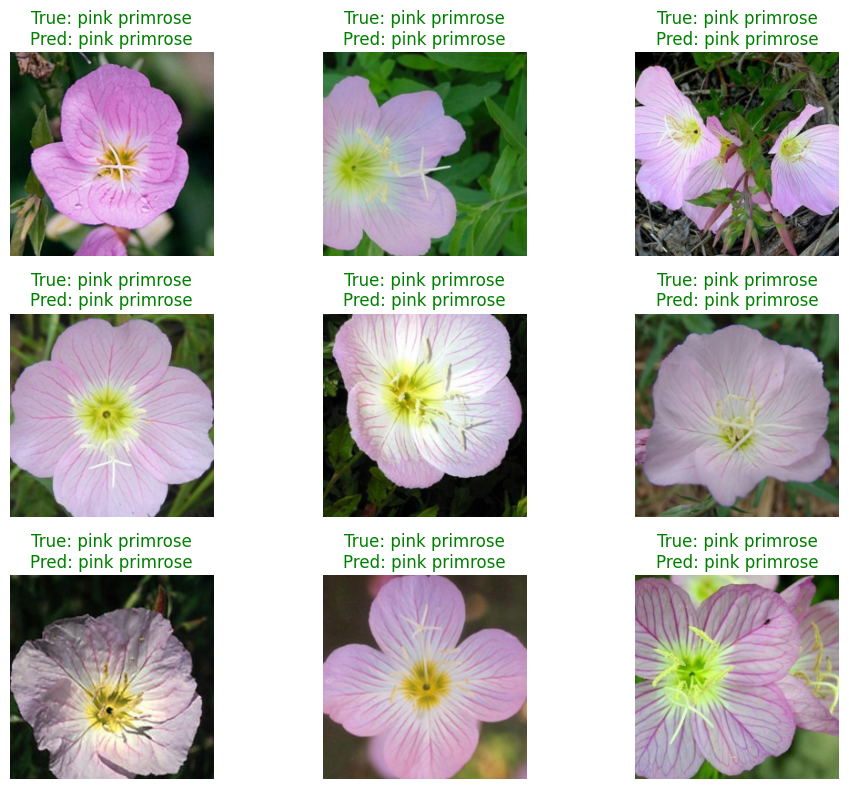


--- Visualizing ResNet50 Predictions ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


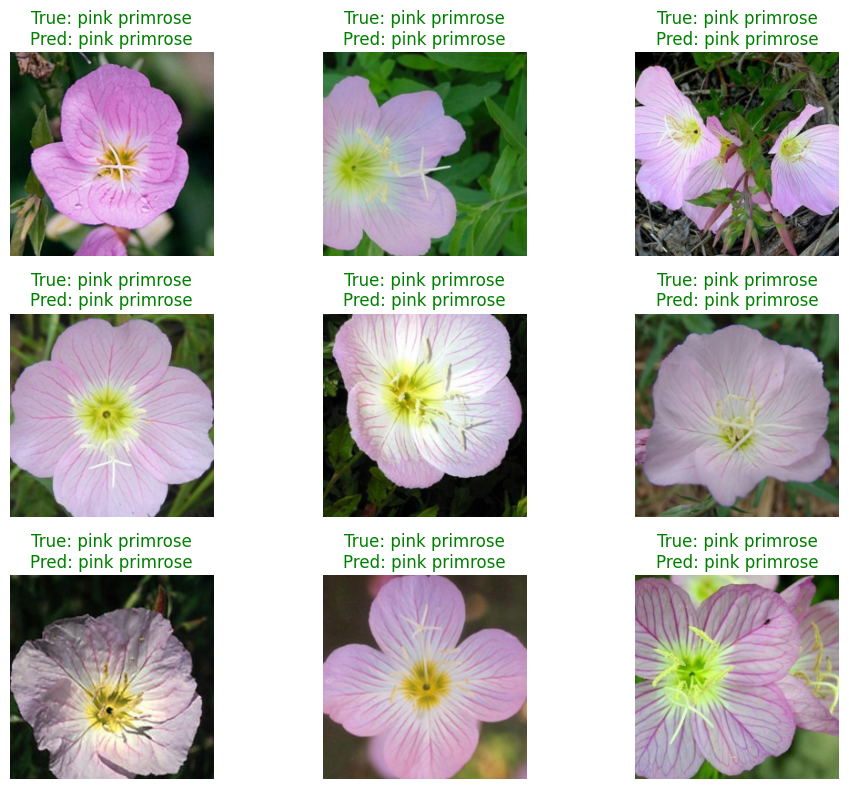


--- Confusion Matrix for ResNet18 (Test Set) ---


Generating Confusion Matrix:   0%|          | 0/193 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Generating Confusion Matrix: 100%|██████████| 193/193 [00:37<00:00,  5.14it/s]


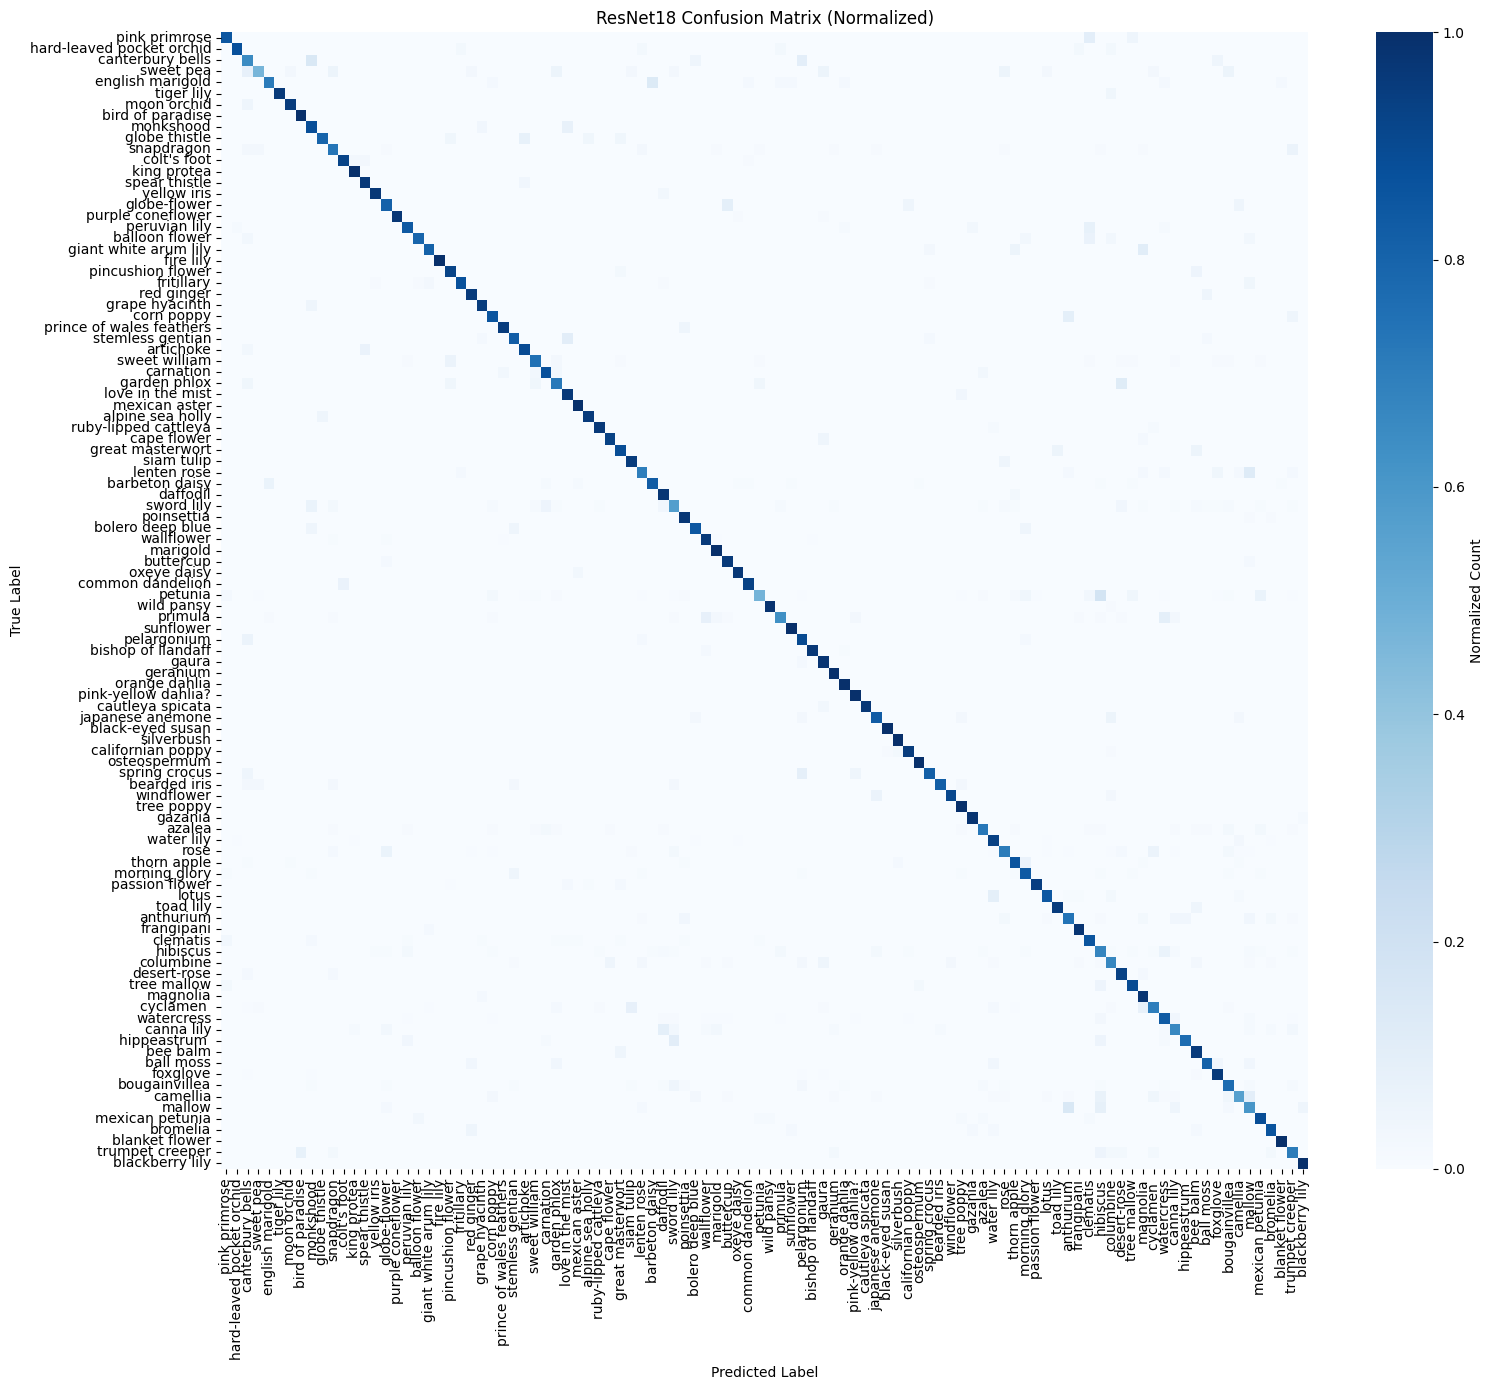


--- Confusion Matrix for ResNet50 (Test Set) ---


Generating Confusion Matrix:   0%|          | 0/193 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Generating Confusion Matrix: 100%|██████████| 193/193 [00:41<00:00,  4.63it/s]


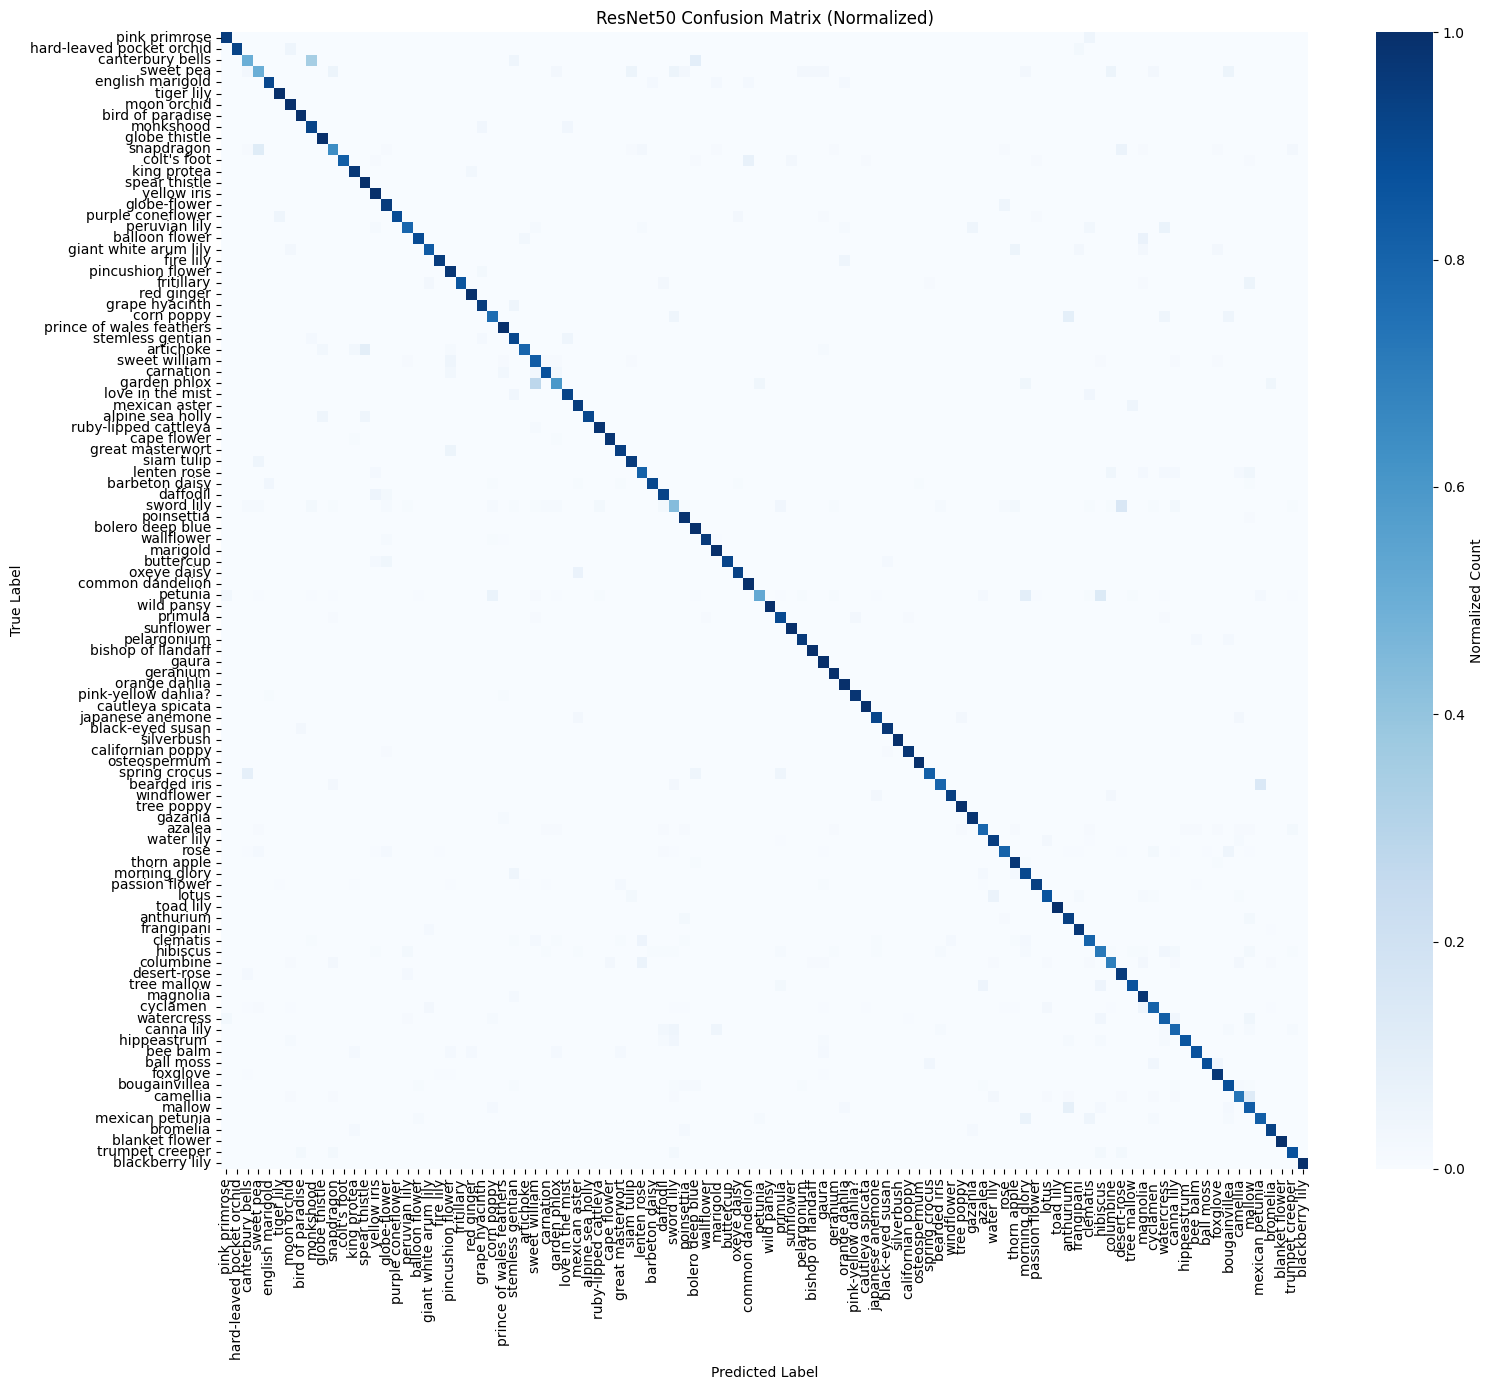

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns # For nicer heatmaps

# Ensure you have your class_names defined from earlier
# class_names = ['pink primrose', 'hard-leaved pocket orchid', ..., 'blackberry lily']

# (Make sure these are still defined from your previous code block)
# normalize_mean = [0.485, 0.456, 0.406]
# normalize_std = [0.229, 0.224, 0.225]
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow_unnormalized(inp, title=None):
    """Imshow for a Tensor, unnormalizing it first."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Unnormalize
    inp = inp * np.array(normalize_std) + np.array(normalize_mean)
    inp = np.clip(inp, 0, 1) # Clip values to [0, 1] to ensure valid image display
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off') # Hide axes

def visualize_predictions(model, dataloader, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far < num_images:
                    images_so_far += 1
                    ax = fig.add_subplot(num_images // 3, 3, images_so_far, xticks=[], yticks=[])
                    ax.axis('off')

                    img_to_show = inputs.cpu().data[j]
                    true_label = class_names[labels[j]]
                    pred_label = class_names[preds[j]]

                    title_color = "green" if pred_label == true_label else "red"
                    ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=title_color)

                    imshow_unnormalized(img_to_show)

                else:
                    break
            if images_so_far == num_images:
                break
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, dataloader, class_names, normalize=True, title='Confusion Matrix'):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Generating Confusion Matrix"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = title + ' (Normalized)'

    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=False, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized Count' if normalize else 'Count'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("\n--- Visualizing ResNet18 Predictions ---")
visualize_predictions(model_resnet18_trained, dataloaders['test'], class_names, num_images=9)

print("\n--- Visualizing ResNet50 Predictions ---")
visualize_predictions(model_resnet50_trained, dataloaders['test'], class_names, num_images=9)

print("\n--- Confusion Matrix for ResNet18 (Test Set) ---")
plot_confusion_matrix(model_resnet18_trained, dataloaders['test'], class_names, normalize=True, title='ResNet18 Confusion Matrix')

print("\n--- Confusion Matrix for ResNet50 (Test Set) ---")
plot_confusion_matrix(model_resnet50_trained, dataloaders['test'], class_names, normalize=True, title='ResNet50 Confusion Matrix')

In [ ]:
import matplotlib
matplotlib.use('Agg')

import os
import io
from PIL import Image
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import imageio
import numpy as np


img_dir = './data/flowers-102/jpg'
label_path = './data/flowers-102/imagelabels.mat'


labels = scipy.io.loadmat(label_path)['labels'][0] - 1
img_paths = sorted(os.listdir(img_dir))


class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold',
    'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot",
    'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily',
    'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger',
    'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
    'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya',
    'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily',
    'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
    'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium',
    'orange dahlia', 'pink-yellow dahlia', 'cautleya spicata', 'japanese anemone', 'black-eyed susan',
    'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy',
    'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus',
    'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow',
    'magnolia', 'cyclamen', 'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'ball moss', 'foxglove',
    'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper',
    'blackberry lily']
frames = []
step = 4
for start in range(0, 102, step):
    selected_classes = list(range(start, min(start + step, 102)))

    samples_by_class = {cls: None for cls in selected_classes}
    for i, label in enumerate(labels):
        if label in selected_classes and samples_by_class[label] is None:
            samples_by_class[label] = img_paths[i]

    class_labels = [class_names[i] for i in selected_classes]
    counts = Counter([l for l in labels if l in selected_classes])
    counts_values = [counts[i] for i in selected_classes]


    fig = plt.figure(figsize=(12, 6.08))

    for idx, cls in enumerate(selected_classes):
        img_path = os.path.join(img_dir, samples_by_class[cls])
        img = mpimg.imread(img_path)
        ax = plt.subplot(2, 4, idx + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(class_names[cls], fontsize=8)
    ax_hist = plt.subplot(2, 1, 2)
    ax_hist.bar(class_labels, counts_values, color='tomato')
    ax_hist.set_title(f'Distribution of Classes {start+1} to {start + len(selected_classes)}')
    ax_hist.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    frames.append(np.array(img))
    buf.close()
    plt.close()

frames.extend([frames[-1]] * 2)
writer = imageio.get_writer('class_samples.mp4', fps=0.8)
for frame in frames:
    writer.append_data(frame)
writer.close()
print("Видео сохранено как 'class_samples.mp4' (каждый кадр = 1.25 секунд)")

FileNotFoundError: [Errno 2] No such file or directory: './data/flowers-102/imagelabels.mat'

In [ ]:
pip install torch torchvision pillow numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the pre-trained ResNet50 model
# weights = models.ResNet50_Weights.DEFAULT  # Use the best available weights (ImageNet1K_V2)
model = models.resnet50(weights='IMAGENET1K_V2') # Or models.resnet50(pretrained=True) for older versions/default weights
model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates, etc.)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using {device} for inference")

Using cuda for inference


In [ ]:
# Define preprocessing transforms (ImageNet normalization)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load an image
img_path = r"/content/Screenshot 2025-07-11 112319.png"
img = Image.open(img_path).convert('RGB')

# Apply preprocessing
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model
input_batch = input_batch.to(device)

In [ ]:
with torch.no_grad(): # Disable gradient calculation for inference
    output = model(input_batch)

# The output will be a tensor of logits (raw predictions).
# To get probabilities, apply softmax.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Load ImageNet class labels (you'll need a mapping from index to label)
# A common way is to download a 'imagenet_classes.txt' file
# For example, from https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Get the top 5 predicted classes
top5_prob, top5_catid = torch.topk(probabilities, 5)

print(f"Top 5 predictions for {img_path}:")
for i in range(top5_prob.size(0)):
    print(f"{categories[top5_catid[i]]}: {top5_prob[i].item()*100:.2f}%")

Top 5 predictions for /content/Screenshot 2025-07-11 112319.png:
earthstar: 9.20%
hen-of-the-woods: 5.66%
bee: 3.39%
daisy: 2.30%
vase: 2.19%


In [ ]:
# Download the ImageNet class labels file
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2025-07-11 05:27:37--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2025-07-11 05:27:37 (82.9 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]

